## 纽约市机动车碰撞事故预测与风险分析

#### 一、数据背景与特征解析
- **数据来源**：纽约市公开数据平台（NYC OpenData）的“Motor Vehicle Collisions”数据集 ，记录了2012年至今的机动车碰撞事件，涵盖警方报告的MV - 104AN表格字段。
    
  [Motor Vehicle Collisions - Crashes](https://catalog.data.gov/dataset/motor-vehicle-collisions-crashes)
- **核心字段特征补充**
    | 字段名 | 类型 | 特征补充说明 |
    | ---- | ---- | ---- |
    | `CRASH_TIME` | 时间型（object ） | **碰撞时间**    可提取小时、分钟等信息，分析事故高发时段，比如早晚高峰是否事故频发。 |
    | `BOROUGH` | 字符串型（object ） |  **行政区**    取值为纽约市的几个行政区，如曼哈顿、布鲁克林、皇后区等。 |
    | `LATITUDE`/`LONGITUDE` | 浮点型（float64 ） | **经纬度**   进行空间分析，可用于绘制事故热点地图，分析事故在地理空间上的分布特征。 |
    | `NUMBER_OF_PERSONS_INJURED` | 浮点型（float64 ） | **受伤人数**   理论上为非负整数，可能存在数据录入错误导致的小数或负数情况。|
    | `NUMBER_OF_PERSONS_KILLED` | 浮点型（float64 ） | **死亡人数**   同理应为非负整数，需排查异常值。与受伤人数结合可综合衡量事故严重程度 。 |
    | `NUMBER_OF_PEDESTRIANS INJURED`/`KILLED` | 整型（int64 ） | **行人受伤/死亡数量**    |
    | `NUMBER_OF_CYCLIST INJURED`/`KILLED` | 整型（int64 ） | **骑行者受伤/死亡数量**    |
    | `NUMBER_OF_MOTORIST INJURED`/`KILLED` | 整型（int64 ） | **机动车驾驶者受伤/死亡数量**   可结合车辆类型、责任因素等分析机动车驾驶者在事故中的伤亡情况 。 |
    | `CONTRIBUTING_FACTOR_VEHICLE_1` - `5` | 字符串型（object ） | **涉事车辆的主要责任原因**   如司机注意力不集中/分心、超速等。存在描述不规范情况。需进行文本标准化处理。 |
    | `COLLISION_ID` | 整型（int64 ） | **事故唯一标识**   可用于排查重复记录 |
    | `VEHICLE_TYPE_CODE_1` - `5` | 字符串型（object ） | **车辆类型**   如轿车、卡车、摩托车等。存在车辆类型分类不明确、编码不一致等问题，需进行整理规范 。 |

- **数据特点补充**：拥有2176342条记录，文件大小481.5MB

#### 二、核心分析问题
- **分类预测**
    - **~~伤亡严重程度（多分类 ）~~**：
      依据伤亡人数阈值，划分为“无伤亡”“轻伤”“重伤”“死亡”类别。**预测效果实在太差了，故这里不讨论**
    - **是否伤亡（二分类）**

## 1. 导入所需库和数据 

In [3]:
import pandas as pd
import re
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes.csv')

C:\Users\smail\AppData\Local\Temp\ipykernel_38500\2192646864.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes.csv')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176342 entries, 0 to 2176341
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [6]:
df['CRASH DATE'].min()

'01/01/2013'

## 2. 数据清理：重复值、缺失值、异常值

1. **数据去重**
    - 根据`COLLISION_ID`删除重复记录
    - 检查并删除完全重复的行

2. **数据筛选与过滤**
    - 删除冗余或不需要的列（如地理位置描述、事故ID等）
    - 合并日期和时间列为`CRASH_DATETIME` datetime类型
    - 删除2022年5月1日之前的历史数据

3. **缺失值处理**
    - 删除地理位置（经纬度）缺失的记录
    - 删除事故主因或主车辆类型缺失的记录
    - 填充事故原因列缺失值为`Unspecified`
    - 填充车辆类型列缺失值为`Unknown`
    - 填充伤亡数字段缺失值为0并转为整数类型
    - 填充区域信息缺失值为`Unknown`

4. **异常值处理**
    - 过滤超出纽约市范围的经纬度数据
    - 修正负的伤亡人数为0

5. **数据整理与输出**
    - 删除次要的事故原因和车辆类型列
    - 重置索引
    - 将处理后的数据保存为CSV文件

处理后的数据集包含：
- 2022年5月以后的交通事故记录
- 完整的地理位置信息
- 标准化的事故原因和车辆类型分类
- 无异常的伤亡统计数据

In [8]:
# 根据COLLISION_ID去除重复值
full_duplicates = df.duplicated().sum()
if full_duplicates > 0:
    df = df.drop_duplicates(subset='COLLISION_ID')
    print(f"删除{full_duplicates}条COLLISION_ID重复的行")

# 删除不需要的列
columns_to_drop = [
    'LOCATION',        # 经纬度已存在，冗余
    'ZIP CODE',        # 缺失值多
    'ON STREET NAME',  # 冗余
    'CROSS STREET NAME',
    'OFF STREET NAME',
    'COLLISION_ID' # 去重后删除
]
df = df.drop(columns=columns_to_drop)

# 合并日期和时间列 转换为datetime类型
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M').dt.time
# 合并为一个DATETIME列
df['CRASH_DATETIME'] = pd.to_datetime(df['CRASH DATE'].astype(str) + ' ' + df['CRASH TIME'].astype(str))
# 删除原始的日期和时间列
df = df.drop(columns=['CRASH DATE', 'CRASH TIME'])

# 删除2020年5月之前的数据
filtered_df = df[~(df['CRASH_DATETIME'] < '2020-05-01')]
print(f"删除了{len(df) - len(filtered_df)}条2020年5月之前的数据")
df = filtered_df

# ===== 空值处理逻辑 =====

# 定义重要特征列表，这些特征如果缺失则删除整行
critical_features = [
    'LATITUDE', 'LONGITUDE',  # 地理位置信息
]

# 删除重要特征中存在缺失值的行
rows_before = len(df)
df = df.dropna(subset=critical_features)
rows_after = len(df)
print(f"删除重要特征缺失值的行数: {rows_before - rows_after} ({((rows_before - rows_after)/rows_before)*100:.2f}%)")

# 删除 CONTRIBUTING FACTOR VEHICLE 1 或 VEHICLE TYPE CODE 1 中任一为空值的行
either_missing = df[(df['CONTRIBUTING FACTOR VEHICLE 1'].isna()) | (df['VEHICLE TYPE CODE 1'].isna())].shape[0]
if either_missing > 0:
    df = df[~((df['CONTRIBUTING FACTOR VEHICLE 1'].isna()) | 
              (df['VEHICLE TYPE CODE 1'].isna()))]
    print(f"删除主责任原因和主车辆类型列有缺失的行数: {either_missing}")

# 处理 CONTRIBUTING FACTOR 列 - 事故原因 => 缺失值填充为 'Unspecified'
contributing_factor_cols = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2','CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4','CONTRIBUTING FACTOR VEHICLE 5']
for col in contributing_factor_cols:
    df[col] = df[col].fillna('Unspecified')

# 处理 VEHICLE TYPE 列 - 车辆类型 => 缺失值填充为 'Unknown'
vehicle_type_cols = ['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5']

# 确保数值型伤亡列没有缺失值（填充为0）
numeric_columns = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED','NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED','NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED','NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED']
for col in numeric_columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(0).astype(int)

# 处理 BOROUGH 列 - 区域信息
if df['BOROUGH'].isnull().any():
    df['BOROUGH'] = df['BOROUGH'].fillna('Unknown')


# ===== 异常值处理 =====
print("\n开始异常值检测和处理...")

# 1. 经纬度异常值处理
# 纽约市经纬度范围
lat_min, lat_max = 40.50, 40.95
lon_min, lon_max = -74.25, -73.70

invalid_lat = df[(df['LATITUDE'] < lat_min) | (df['LATITUDE'] > lat_max)].shape[0]
invalid_lon = df[(df['LONGITUDE'] < lon_min) | (df['LONGITUDE'] > lon_max)].shape[0]

if invalid_lat > 0 or invalid_lon > 0:
    print(f"检测到 {invalid_lat} 个异常纬度值 和 {invalid_lon} 个异常经度值")
    # 过滤异常经纬度
    df = df[(df['LATITUDE'] >= lat_min) & (df['LATITUDE'] <= lat_max) &
            (df['LONGITUDE'] >= lon_min) & (df['LONGITUDE'] <= lon_max)]
    print(f"删除异常经纬度后的数据形状: {df.shape}")

# 2. 伤亡人数异常值处理
# 确保伤亡人数非负
for col in numeric_columns:
    negative_values = (df[col] < 0).sum()
    if negative_values > 0:
        print(f"检测到 {col} 列有 {negative_values} 个负值")
        df.loc[df[col] < 0, col] = 0  # 将负值设为0

删除了1675196条2020年5月之前的数据
删除重要特征缺失值的行数: 37981 (7.58%)
删除主责任原因和主车辆类型列有缺失的行数: 7367

开始异常值检测和处理...
检测到 4263 个异常纬度值 和 4295 个异常经度值
删除异常经纬度后的数据形状: (451499, 22)


In [9]:
# 删除不需要的列
columns_to_drop_ = [
    'CONTRIBUTING FACTOR VEHICLE 3', 
    'CONTRIBUTING FACTOR VEHICLE 4', 
    'CONTRIBUTING FACTOR VEHICLE 5', 
    'VEHICLE TYPE CODE 3', 
    'VEHICLE TYPE CODE 4', 
    'VEHICLE TYPE CODE 5', 
]
df = df.drop(columns=columns_to_drop_)

# 重置索引
df = df.reset_index(drop=True)

# 输出数据处理摘要
print("\n数据预处理完成！")
print(f"处理后的数据集形状: {df.shape}")
print("各列缺失值统计:")
print(df.isnull().sum())

# 保存处理后的数据
df.to_csv('processed_data.csv', index=False)


数据预处理完成！
处理后的数据集形状: (451499, 16)
各列缺失值统计:
BOROUGH                               0
LATITUDE                              0
LONGITUDE                             0
NUMBER OF PERSONS INJURED             0
NUMBER OF PERSONS KILLED              0
NUMBER OF PEDESTRIANS INJURED         0
NUMBER OF PEDESTRIANS KILLED          0
NUMBER OF CYCLIST INJURED             0
NUMBER OF CYCLIST KILLED              0
NUMBER OF MOTORIST INJURED            0
NUMBER OF MOTORIST KILLED             0
CONTRIBUTING FACTOR VEHICLE 1         0
CONTRIBUTING FACTOR VEHICLE 2         0
VEHICLE TYPE CODE 1                   0
VEHICLE TYPE CODE 2              148872
CRASH_DATETIME                        0
dtype: int64


## 3.特征工程
### 3.1 对于'CONTRIBUTING FACTOR VEHICLE 1-5' 和 'VEHICLE TYPE CODE 1-5' 列 ：
1. **精细化分类**：把交通事故中的车辆类型和事故原因，通过预设的规则（如关键词匹配），分别归类到22种车辆类型（如救护车、皮卡、电动车）和12种事故原因（如分心驾驶、机械故障）中。
2. **数据清洗**：删除无法准确分类的无效数据（如类型为"unknown"的记录），并统计各类别的占比，方便后续分析。

In [11]:
processed_df = pd.read_csv('processed_data.csv')
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451499 entries, 0 to 451498
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   BOROUGH                        451499 non-null  object 
 1   LATITUDE                       451499 non-null  float64
 2   LONGITUDE                      451499 non-null  float64
 3   NUMBER OF PERSONS INJURED      451499 non-null  int64  
 4   NUMBER OF PERSONS KILLED       451499 non-null  float64
 5   NUMBER OF PEDESTRIANS INJURED  451499 non-null  int64  
 6   NUMBER OF PEDESTRIANS KILLED   451499 non-null  int64  
 7   NUMBER OF CYCLIST INJURED      451499 non-null  int64  
 8   NUMBER OF CYCLIST KILLED       451499 non-null  int64  
 9   NUMBER OF MOTORIST INJURED     451499 non-null  int64  
 10  NUMBER OF MOTORIST KILLED      451499 non-null  int64  
 11  CONTRIBUTING FACTOR VEHICLE 1  451499 non-null  object 
 12  CONTRIBUTING FACTOR VEHICLE 2 

In [12]:
# 定义要分析的列
contributing_cols = [f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1, 3)]
vehicle_type_cols = [f'VEHICLE TYPE CODE {i}' for i in range(1, 3)]

# 1. 分析CONTRIBUTING FACTOR VEHICLE列
print("="*80)
print("CONTRIBUTING FACTOR VEHICLE 前50个最高频率项:")
print("="*80)

# 合并所有CONTRIBUTING FACTOR列的值
all_factors = pd.concat([df[col] for col in contributing_cols])
top_factors = all_factors.value_counts().head(50)

# 打印结果
print(top_factors)

# 2. 分析VEHICLE TYPE CODE列
print("\n" + "="*80)
print("VEHICLE TYPE CODE 前50个最高频率项:")
print("="*80)

# 合并所有VEHICLE TYPE列的值
all_vehicle_types = pd.concat([df[col] for col in vehicle_type_cols])
top_vehicle_types = all_vehicle_types.value_counts().head(50)

# 打印结果
print(top_vehicle_types)

CONTRIBUTING FACTOR VEHICLE 前50个最高频率项:
Unspecified                                              513585
Driver Inattention/Distraction                           131978
Failure to Yield Right-of-Way                             33620
Following Too Closely                                     30810
Passing or Lane Usage Improper                            22385
Passing Too Closely                                       18726
Unsafe Speed                                              18710
Other Vehicular                                           18710
Backing Unsafely                                          15229
Traffic Control Disregarded                               14999
Turning Improperly                                        11277
Driver Inexperience                                       10578
Unsafe Lane Changing                                       9553
Alcohol Involvement                                        8449
Reaction to Uninvolved Vehicle                             6182
P

In [13]:
# ======================
# 全面车辆类型分类规则
# ======================
vehicle_category_patterns = {
    'ambulance': [r'\b(AMBULANCE|EMS|FDNY AMB|EMT|RESCUE|MEDIC)\b'],
    'fire_truck': [r'\b(FIRE TRUCK|PUMPER|LADDER|FD|FDNY|FIRE DEPT|FIRETRUCK)\b'],
    'truck': [
        r'\b(TRUCK|FREIGHT|DUMP|TOW|SEMI|BOX TRUCK|Tractor Truck|Flat Bed|Tanker|Trailer|Dump|PK|Garbage or Refuse)\b',
        r'\b(CONCRETE MIXER|Stake or Rack|Refrigerated Van|Beverage Truck)\b'  # 新增高频卡车类型
    ],
    'bus': [r'\b(BUS|SCHOOL|TRANSIT|MTA|OMNIBUS|SHUTTLE|TOUR|School Bus)\b'],
    'sedan': [r'\b(SEDAN|4DR|COUPE|4 dr sedan)\b', r'\b(CAMRY|ACCORD|FUSION)\b'],
    'suv': [
        r'\b(SUV|4X4|CROSSOVER|Station Wagon/Sport Utility Vehicle)\b',  # 匹配高频SUV描述
        r'\b(RAV4|CRV|ESCAPE)\b'
    ],
    'pickup_truck': [r'\b(PICKUP|F-150|SILVERADO|RAM|TACOMA|CREW CAB|Pick-up Truck)\b'],
    'motorcycle': [
        r'\b(MOTORCYCLE|BIKE|CYCLE|Motorbike|Motorscooter)\b',  # 新增高频拼写
        r'\b(SCOOTER|MOPED|E-BIKE|MOPED|E-Scooter)\b'  # 合并电摩/摩托类别
    ],
    'bicycle': [r'\b(BIKE|BICYCLE|E-BIKE|Bike)\b'],  # 统一大小写和拼写
    'scooter': [r'\b(SCOOTER|E-SCOOTER|VESPA)\b'],
    'minivan': [r'\b(MINIVAN|VAN|Van)\b'],  # 匹配小写van
    'taxi': [r'\b(TAXI|YELLOW CAB|Yellow Cab)\b'],
    'delivery_vehicle': [
        r'\b(DELIVERY|COMMERCIAL|UPS|FEDEX|Tractor Truck Diesel|Tractor Truck Gasoline)\b',  # 新增货运卡车类型
        r'\b(Armored Truck|Refrigerated Van)\b'  # 补充商用车辆
    ],
    'unknown_vehicle': [r'\b(UNKNOWN|N/A|NOT SPECIFIED|Unknown|UNK)\b'],  # 覆盖数据中的UNK/unknown
    # 低频但需保留的类型（根据数据适当精简）
    'hatchback': [r'\bHATCHBACK\b'],
    'convertible': [r'\bCONVERTIBLE\b'],
    'station_wagon': [r'\b(STATION WAGON|WAGON)\b'],
    'electric_car': [r'\b(ELECTRIC|EV|HYBRID)\b'],
    'luxury_car': [r'\b(LUXURY|BMW|MERCEDES|AUDI)\b'],
    'recreational': [r'\b(ATV|RV|CAMPER|JETSKI|SNOWMOBILE)\b'],
    'public_service': [r'\b(USPS|POLICE|NYPD|STREET SWEEP|SNOW PLOW)\b'],
    'construction': [r'\b(EXCAVATOR|CRANE|LOADER|BOBCAT|CONSTRUCTION)\b']
}

# 预编译正则表达式（不区分大小写）
compiled_patterns = {
    cat: [re.compile(pat, re.IGNORECASE) for pat in pats]
    for cat, pats in vehicle_category_patterns.items()
}

# ==============================
# 精细化事故原因分类规则
# ==============================
factor_categories = {
    'Distraction': [
        r'driver inattention|passenger distraction|outside car distraction|Passenger Distraction|Outside Car Distraction',
        r'cell phone (hand(?:-?held)?)|texting|navigation device|Cell Phone|Using On Board Navigation Device',
        r'headphones|Eating or Drinking'  # 新增高频分心行为
    ],
    'Risky Driving': [
        r'aggressive driving|road rage|unsafe speed|unsafe lane change|Aggressive Driving/Road Rage|Unsafe Speed|Unsafe Lane Changing',
        r'following too close|improper passing|improper turning|Following Too Closely|Turning Improperly|Passing or Lane Usage Improper',
        r'Passing Too Closely|Backing Unsafely'  # 补充变道/倒车风险
    ],
    'Impairment': [
        r'alcohol|drugs \(illegal\)|fatigued|drowsy|fell asleep|Alcohol Involvement|Fatigued/Drowsy|Fell Asleep',
        r'illness|prescription medication|physical disability|Illnes|Physical Disability|Prescription Medication'
    ],
    'Vehicle Mechanical': [
        r'brakes defective|steering failure|accelerator defective|Brakes Defective|Steering Failure|Accelerator Defective',
        r'tire failure|headlights defective|vehicle vandalism|Tire Failure/Inadequate|Headlights Defective|Vehicle Vandalism',
        r'Tinted Windows|Tow Hitch Defective'  # 新增机械故障类型
    ],
    'Environmental': [
        r'pavement slippery|view obstructed|glare|obstruction|View Obstructed/Limited|Pavement Slippery|Obstruction/Debris|Glare',
        r'animals action|pavement defective|traffic control device|Animals Action|Pavement Defective|Traffic Control Device Improper/Non-Working'
    ],
    'Regulatory Violation': [
        r'traffic control disregard|speeding|failure to yield|Traffic Control Disregarded|Speeding|Failure to Yield Right-of-Way',
        r'failure to keep right|traffic light violation|Failure to Keep Right'
    ],
    'Driver Inexperience': [r'driver inexperience|new driver|inexperienced|Driver Inexperience'],
    'Other_Parties': [
        r'pedestrian error|bicyclist confusion|uninvolved vehicle|Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
        r'Reaction to Uninvolved Vehicle'  # 新增第三方反应类型
    ],
    'Special_Conditions': [r'oversized vehicle|driverless|runaway vehicle|Oversized Vehicle|Driverless/Runaway Vehicle'],
    'Unknown_Cause': ['Unspecified', '1', '80', 'Other Vehicular', 'Other Vehicular']  # 合并重复项
}

# 编译事故原因正则表达式（去重、合并高频模式）
factor_patterns = {
    cat: re.compile('|'.join(list(set(pats))), re.IGNORECASE)  # 去重处理
    for cat, pats in factor_categories.items() if isinstance(pats, list)
}

# ==============================
# 车辆分类函数（多级优先级匹配）
# ==============================
def categorize_vehicle(model):
    # 修复空值处理逻辑
    if pd.isna(model) or (isinstance(model, str) and not model.strip()):
        return 'unknown_vehicle'
    
    model_str = str(model).strip().upper()
    
    # 优先级1：明确类型关键词
    priority_categories = {
        'ambulance': r'AMBULANCE|EMS',
        'fire_truck': r'FIRE TRUCK|PUMPER',
        'bicycle': r'Bike|BICYCLE',
        'scooter': r'SCOOTER|E-SCOOTER',
        'pickup_truck': r'PICKUP|F-150',
        'minivan': r'MINIVAN|VAN',
        'hatchback': r'HATCHBACK',
        'convertible': r'CONVERTIBLE',
        'station_wagon': r'STATION WAGON',
        'electric_car': r'EV|ELECTRIC',
        'luxury_car': r'BMW|MERCEDES|AUDI',
        'taxi': r'TAXI|YELLOW',
        'delivery_vehicle': r'DELIVERY|UPS|FEDEX',
        'trailer': r'TRAILER'
    }
    
    for category, pattern in priority_categories.items():
        if re.search(pattern, model_str):
            return category
    
    # 优先级2：正则表达式匹配
    for category, patterns in compiled_patterns.items():
        for pat in patterns:
            if pat.search(model_str):
                return category
    
    # 优先级3：通用分类
    if re.search(r'\b(4DR|SEDAN|COUPE)\b', model_str):
        return 'sedan'
    if re.search(r'\b(SUV|CROSSOVER)\b', model_str):
        return 'suv'
    if re.search(r'\b(TRUCK|FREIGHT)\b', model_str):
        return 'truck'
    if re.search(r'\b(BUS|TRANSIT)\b', model_str):
        return 'bus'
    if re.search(r'\b(MOTORCYCLE|BIKE)\b', model_str):
        return 'motorcycle'
    
    # 无法分类的归入未知
    return 'unknown_vehicle'

# ==============================
# 事故原因分类函数（正则优先匹配）
# ==============================
def categorize_factor(factor):
    # 修复空值处理逻辑
    if pd.isna(factor) or (isinstance(factor, str) and not factor.strip()):
        return 'Unknown_Cause'
    
    factor_lower = str(factor).strip().lower()
    
    # 直接匹配特殊值
    if factor_lower in [str(x).lower() for x in factor_categories['Unknown_Cause']]:
        return 'Unknown_Cause'
    
    # 正则表达式优先匹配
    for category, pattern in factor_patterns.items():
        if pattern.search(factor_lower):
            return category
    
    # 关键词模糊匹配
    keyword_mapping = {
        'Distraction': ['distraction', 'cell phone', 'texting', 'headphones'],
        'Risky Driving': ['aggressive', 'speed', 'lane change', 'following too close'],
        'Impairment': ['alcohol', 'drugs', 'fatigued', 'asleep', 'illness'],
        'Vehicle Mechanical': ['brakes', 'steering', 'tire', 'headlights'],
        'Environmental': ['pavement', 'view', 'glare', 'obstruction', 'animals'],
        'Regulatory Violation': ['traffic control', 'speeding', 'yield', 'keep right'],
        'Driver Inexperience': ['inexperienced', 'new driver'],
        'Equipment Misuse': ['electronic device', 'navigation', 'headphones'],
        'Unsafe Maneuver': ['backing', 'turning', 'lane drifting'],
        'Other_Parties': ['pedestrian', 'bicyclist', 'uninvolved'],
        'Special_Conditions': ['oversized', 'driverless', 'runaway']
    }
    
    for category, keywords in keyword_mapping.items():
        for kw in keywords:
            if kw in factor_lower:
                return category
    
    # 最终无法分类的归入未知
    return 'Unknown_Cause'

# ==============================
# 数据处理主流程（！删除未分类行逻辑！） --- 这里的处理可能过于主观了，但是删除了之后模型整体效果会变好很多
# ==============================

processed_df = pd.read_csv('processed_data.csv')
print(f"成功加载数据，包含{len(processed_df)}条记录")

# 车辆类型分类处理
vehicle_columns = [col for col in processed_df.columns if col.startswith('VEHICLE TYPE CODE')]
for col in vehicle_columns:
    processed_df[col] = processed_df[col].apply(categorize_vehicle)

# 事故原因分类处理
factor_columns = [col for col in processed_df.columns if col.startswith('CONTRIBUTING FACTOR VEHICLE')]
for col in factor_columns:
    new_col = f"{col}_CATEGORY"
    processed_df[new_col] = processed_df[col].apply(categorize_factor)

# 筛选，删除未分类的行（车辆或原因为unknown_vehicle/Unknown_Cause的行）
valid_mask = (
    processed_df[vehicle_columns].ne('unknown_vehicle').all(axis=1) &  # 所有车辆列均不为unknown_vehicle
    processed_df[[f"{col}_CATEGORY" for col in factor_columns]].ne('Unknown_Cause').all(axis=1)  # 所有原因列均不为Unknown_Cause
)

# 筛选，删除 CONTRIBUTING_FACTOR_VEHICLE_1 和 VEHICLE_TYPE_CODE_1 未分类的行
# valid_mask = (
#     # 主责原因列（VEHICLE_1）不为 Unknown_Cause
#     processed_df[f"CONTRIBUTING FACTOR VEHICLE 1"].ne('Unknown_Cause') &  
#     # 主车辆类型列（VEHICLE_1）不为 unknown_vehicle
#     processed_df["VEHICLE TYPE CODE 1"].ne('unknown_vehicle')  
# )


processed_df = processed_df[valid_mask].reset_index(drop=True)
print(f"\n数据清洗后剩余{len(processed_df)}条有效记录")

# ==============================
# 结果分析与输出（仅显示分类后特征）
# ==============================
def analyze_categorized_distribution(df, vehicle_prefix='VEHICLE TYPE CODE', factor_prefix='CONTRIBUTING FACTOR VEHICLE'):
    # 处理车辆类型分类分布
    vehicle_columns = [col for col in df.columns if col.startswith(vehicle_prefix)]
    if vehicle_columns:
        print("\n车辆类型分类分布：")
        for col in vehicle_columns:
            distribution = df[col].value_counts(normalize=True, dropna=False).reset_index()
            distribution.columns = ['类别', '占比']
            
            # 合并占比<0.5%的类别为"其他"
            main_categories = distribution[distribution['占比'] >= 0.005]['类别'].tolist()
            others = distribution[distribution['占比'] < 0.005]['占比'].sum()
            distribution = distribution[distribution['类别'].isin(main_categories)].copy()
            distribution = pd.concat([distribution, pd.DataFrame({'类别': ['其他'], '占比': [others]})])
            
            # 格式化输出
            distribution['占比'] = distribution['占比'].map(lambda x: f"{x*100:.1f}%")
            print(f"\n{col}:")
            print(distribution.to_string(index=False, justify='left'))

    # 处理事故原因分类分布
    factor_category_columns = [col for col in df.columns if col.startswith(factor_prefix) and '_CATEGORY' in col]
    if factor_category_columns:
        print("\n事故原因分类分布：")
        for col in factor_category_columns:
            distribution = df[col].value_counts(normalize=True, dropna=False).reset_index()
            distribution.columns = ['类别', '占比']
            
            # 排除Unknown_Cause并保留前8大类别
            distribution = distribution[distribution['类别'] != 'Unknown_Cause'].head(8)
            distribution['占比'] = distribution['占比'].map(lambda x: f"{x*100:.1f}%")
            
            # 格式化输出
            print(f"\n{col}:")
            print(distribution.to_string(index=False, justify='left'))

# 调用函数（显示分类后的特征）
analyze_categorized_distribution(processed_df)

成功加载数据，包含451499条记录

数据清洗后剩余39108条有效记录

车辆类型分类分布：

VEHICLE TYPE CODE 1:
类别            占比   
        sedan 46.5%
station_wagon 33.3%
        truck  6.9%
   motorcycle  4.4%
         taxi  4.0%
          bus  2.6%
      minivan  0.7%
      scooter  0.7%
    ambulance  0.5%
           其他  0.4%

VEHICLE TYPE CODE 2:
类别            占比   
        sedan 37.3%
station_wagon 26.6%
   motorcycle 18.8%
        truck  8.1%
      scooter  2.9%
          bus  2.5%
         taxi  2.3%
      minivan  0.7%
           其他  0.8%

事故原因分类分布：

CONTRIBUTING FACTOR VEHICLE 1_CATEGORY:
类别                   占比   
         Distraction 43.0%
       Risky Driving 27.9%
Regulatory Violation 11.7%
       Other_Parties  6.4%
       Environmental  5.4%
 Driver Inexperience  3.2%
          Impairment  1.0%
  Special_Conditions  0.8%

CONTRIBUTING FACTOR VEHICLE 2_CATEGORY:
类别                   占比   
         Distraction 43.6%
       Risky Driving 31.6%
Regulatory Violation 11.5%
       Other_Parties  4.6%
       Environme

#### 描述性分析与相关性分析

数据基本信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39108 entries, 0 to 39107
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   BOROUGH                                 39108 non-null  object 
 1   LATITUDE                                39108 non-null  float64
 2   LONGITUDE                               39108 non-null  float64
 3   NUMBER OF PERSONS INJURED               39108 non-null  int64  
 4   NUMBER OF PERSONS KILLED                39108 non-null  float64
 5   NUMBER OF PEDESTRIANS INJURED           39108 non-null  int64  
 6   NUMBER OF PEDESTRIANS KILLED            39108 non-null  int64  
 7   NUMBER OF CYCLIST INJURED               39108 non-null  int64  
 8   NUMBER OF CYCLIST KILLED                39108 non-null  int64  
 9   NUMBER OF MOTORIST INJURED              39108 non-null  int64  
 10  NUMBER OF MOTORIST KILLED               39108 non-

C:\Users\smail\AppData\Local\Temp\ipykernel_38500\1169779033.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='SEVERITY', data=processed_df, palette='viridis')


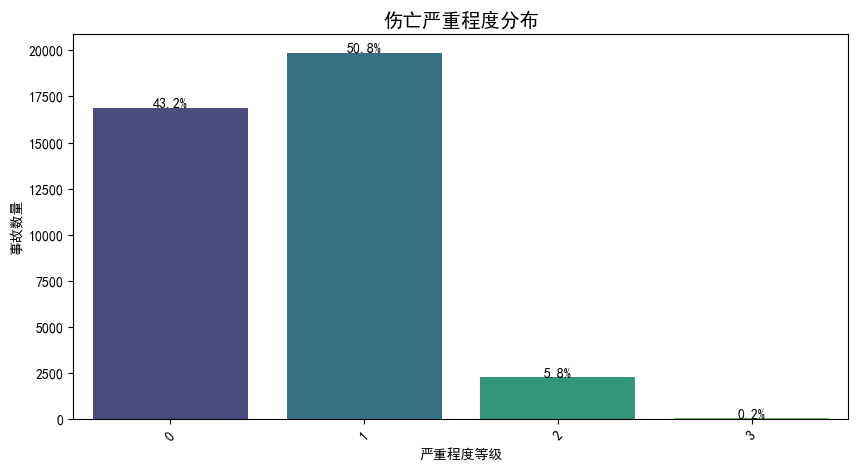

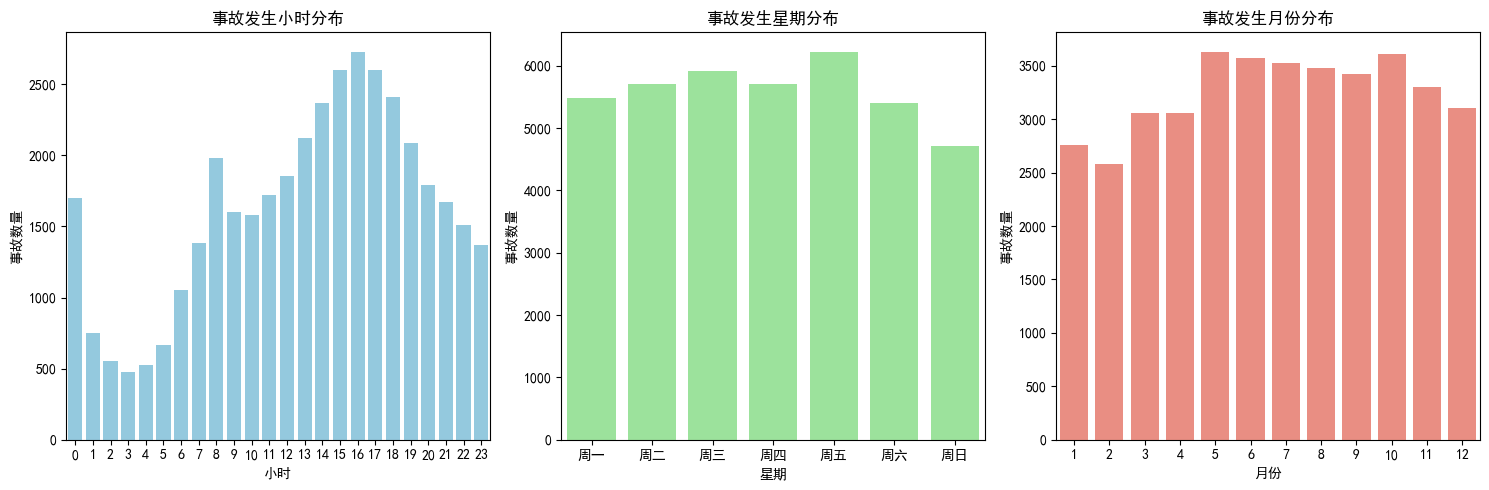

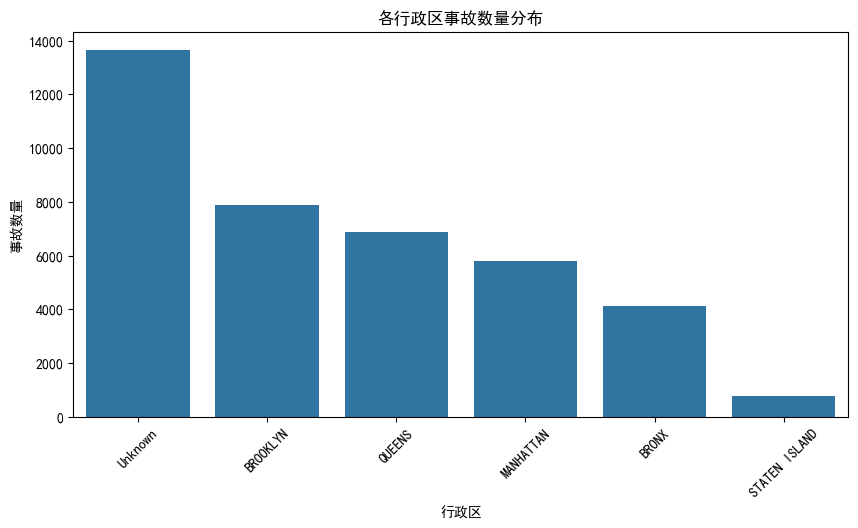

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体显示
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False

# ------------------------------
# 1. 数据基本信息与关键统计量
# ------------------------------
print("数据基本信息：")
processed_df.info()

# 关键数值特征统计
numeric_features = [
    'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
    'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
    'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
    'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED'
]

print("\n数值特征描述性统计：")
print(processed_df[numeric_features].describe().round(2))

# ------------------------------
# 2. 伤亡严重程度分布
# ------------------------------


def get_severity(row):
    # 基础变量提取
    total_killed = row['NUMBER OF PERSONS KILLED']
    total_injured = row['NUMBER OF PERSONS INJURED']
    pedestrian_killed = row['NUMBER OF PEDESTRIANS KILLED']
    cyclist_killed = row['NUMBER OF CYCLIST KILLED']
    motorist_killed = row['NUMBER OF MOTORIST KILLED']
    pedestrian_injured = row['NUMBER OF PEDESTRIANS INJURED']
    cyclist_injured = row['NUMBER OF CYCLIST INJURED']
    motorist_injured = row['NUMBER OF MOTORIST INJURED']
    
    # 优先级1：有死亡情况（提升行人/骑行者死亡的权重）
    if total_killed > 0:
        # 行人或骑行者死亡，直接定义为最严重级别
        if pedestrian_killed > 0 or cyclist_killed > 0:
            return 3  # FATAL_PEDESTRIAN/CYCLIST
        else:
            return 3  # FATAL_MOTORIST
    
    # 优先级2：重伤情况（多人受伤或弱势群体受伤）
    elif total_injured >= 3:
        # 若包含行人或骑行者受伤，提升严重级别
        if pedestrian_injured > 0 or cyclist_injured > 0:
            return 2  # SEVERE_PEDESTRIAN/CYCLIST
        else:
            return 2  # SEVERE_MOTORIST
    
    # 优先级3：轻伤情况
    elif total_injured > 0:
        # 若行人或骑行者受伤，仍视为较严重
        if pedestrian_injured > 0 or cyclist_injured > 0:
            return 1  # MINOR_PEDESTRIAN/CYCLIST
        else:
            return 1  # MINOR_MOTORIST
    
    # 优先级4：无伤亡
    else:
        return 0  # NONE

processed_df['SEVERITY'] = processed_df.apply(get_severity, axis=1)


# 可视化严重程度分布
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='SEVERITY', data=processed_df, palette='viridis')
plt.title('伤亡严重程度分布', fontsize=14)
plt.xlabel('严重程度等级')
plt.ylabel('事故数量')
plt.xticks(rotation=45)

# 添加百分比标注
total = len(processed_df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3,
            f'{height/total:.1%}', ha='center', fontsize=10)
plt.show()

# ------------------------------
# 3. 时间特征分析
# ------------------------------
# 转换时间格式
processed_df['CRASH_DATETIME'] = pd.to_datetime(processed_df['CRASH_DATETIME'])
processed_df['HOUR'] = processed_df['CRASH_DATETIME'].dt.hour
processed_df['DAY_OF_WEEK'] = processed_df['CRASH_DATETIME'].dt.dayofweek  # 0=周一，6=周日
processed_df['MONTH'] = processed_df['CRASH_DATETIME'].dt.month

# 事故时间分布
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x='HOUR', data=processed_df, color='skyblue')
plt.title('事故发生小时分布')
plt.xlabel('小时')
plt.ylabel('事故数量')

plt.subplot(1, 3, 2)
sns.countplot(x='DAY_OF_WEEK', data=processed_df, color='lightgreen')
plt.title('事故发生星期分布')
plt.xlabel('星期')
plt.ylabel('事故数量')
plt.xticks(range(7), ['周一', '周二', '周三', '周四', '周五', '周六', '周日'])

plt.subplot(1, 3, 3)
sns.countplot(x='MONTH', data=processed_df, color='salmon')
plt.title('事故发生月份分布')
plt.xlabel('月份')
plt.ylabel('事故数量')

plt.tight_layout()
plt.show()

# ------------------------------
# 4. 空间特征分析
# ------------------------------
plt.figure(figsize=(10, 5))
sns.countplot(x='BOROUGH', data=processed_df, order=processed_df['BOROUGH'].value_counts().index)
plt.title('各行政区事故数量分布')
plt.xlabel('行政区')
plt.ylabel('事故数量')
plt.xticks(rotation=45)
plt.show()

### 3.2 对交通事故数据进行**目标变量构建**和**特征工程**：  

1. **目标变量构建**  
   - 根据伤亡人数及类型（行人/骑行者优先），将事故严重程度划分为4级（`SEVERITY`）
   - 生成二分类标签（`HAS_CASUALTY`表示是否有伤亡）。  **后面使用这个作为目标变量**

2. **数据清洗与权重计算**  
   - 仅保留前2辆车辆及其事故原因的非空数据。  
   - 基于伤亡和严重程度，为每个事故原因和车辆类型计算危险权重（`factor_weights`/`vehicle_weights`），用于后续评分。  

3. **危险值计算**  
   - 结合前2个事故原因和车辆类型的权重，计算综合危险评分（`DANGER_SCORE`），并对结果取对数平滑。  

4. **独热编码与特征组合**  
   - 对高频事故原因和车辆类型进行独热编码（保留出现频率≥3%的类别）。  
   - 创建组合特征：  
     - `DANGER_VEHICLE_COUNT`：危险车辆（卡车/公交/摩托车）数量。  
     - `RISK_FACTOR_COUNT`：高风险原因（危险驾驶/酒驾/违规）数量。  

5. **时间特征工程**  
   - 从时间戳中提取小时、月份、是否高峰时段、节假日等特征，并通过三角函数处理周期性（如小时/月份的正弦/余弦变换）。  

6. **特征验证与分析**  
   - 分析危险值与严重程度的分布关系，计算特征与目标变量（`SEVERITY`）的相关性，筛选关键特征。  

#### **总结：危险值计算的核心逻辑**
DANGER_SCORE 的计算流程：
原始数据（车辆类型、事故原因） → 统计分组权重（基于历史数据的伤亡/严重程度） → 主副列加权求和 → 对数变换 → 最终危险值
- **关键点**：权重仅依赖历史数据的统计结果（如某类车辆的平均死亡人数），但`SEVERITY`本身依赖`HAS_CASUALTY`，可能导致特征与目标的间接相关性。问题是，如果不这样做，这个数据做出来的预测结果根本用不了。

In [30]:
# ==============================
# 目标变量构建（采用四级分类方案）
# ==============================
## get_severity再 ##
processed_df['HAS_CASUALTY'] = processed_df['SEVERITY'] > 0  # 二分类目标

# 检查类别分布
print("\n伤亡严重程度分布:")
print(processed_df['SEVERITY'].value_counts(normalize=True).sort_index())

# ==============================
# 4. 数据清洗？与特征工程
# ==============================
# 4.1 清洗数据（保留至少前2个因素和车辆类型）
min_non_null = 2  # 调整为保留前2列
vehicle_cols = [f'VEHICLE TYPE CODE {i}' for i in range(1, 3)]  # 仅保留1和2
factor_cols = [f'CONTRIBUTING FACTOR VEHICLE {i}' for i in range(1, 3)]  

processed_df = processed_df.dropna(subset=vehicle_cols + factor_cols)  # 检查前2列非空

# 4.2 基于统计的危险值计算（计算权重时排除Unknown_Cause）
def calculate_weights(df, group_col, injury_col, kill_col, severity_col):
    stats = df[df[group_col] != 'Unknown_Cause'].groupby(group_col).agg({
        injury_col: 'mean',
        kill_col: 'mean',
        severity_col: 'mean'
    })
    stats['WEIGHT'] = (stats[kill_col] * 3 + stats[injury_col] * 1.5 + stats[severity_col])
    return stats['WEIGHT'].to_dict()

# 计算权重
factor_weights = calculate_weights(processed_df, 'CONTRIBUTING FACTOR VEHICLE 1',
                                 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'SEVERITY')

vehicle_weights = calculate_weights(processed_df, 'VEHICLE TYPE CODE 1',
                                  'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'SEVERITY')

# 危险值计算函数（仅处理前2列）
def calculate_danger_score(row):
    factor_score = sum(
        factor_weights.get(row[f'CONTRIBUTING FACTOR VEHICLE {i}'], 0) * (1.0 - 0.1*(i-1))
        for i in range(1, 3)  
        if pd.notna(row[f'CONTRIBUTING FACTOR VEHICLE {i}']) 
        and row[f'CONTRIBUTING FACTOR VEHICLE {i}'] != 'Unknown_Cause'
    )
    
    vehicle_score = sum(
        vehicle_weights.get(row[f'VEHICLE TYPE CODE {i}'], 0) * (1.0 - 0.1*(i-1))
        for i in range(1, 3)  
        if pd.notna(row[f'VEHICLE TYPE CODE {i}']) 
        and row[f'VEHICLE TYPE CODE {i}'] != 'unknown_vehicle'
    )
    
    return np.log1p(factor_score * 0.55 + vehicle_score * 0.45)

processed_df['DANGER_SCORE'] = processed_df.apply(calculate_danger_score, axis=1)


# ==============================
# 5. 独热编码与特征组合
# ==============================
# 5.1 选择主要类别
def get_major_categories(series, min_freq=0.03):
    counts = series[~series.isin(['Unknown_Cause', 'unknown_vehicle'])].value_counts(normalize=True)
    return counts[counts >= min_freq].index.tolist()

# 提取前2列的因素和车辆类型数据
factor_series = processed_df[factor_cols].stack()  
vehicle_series = processed_df[vehicle_cols].stack()

major_factors = get_major_categories(factor_series)
major_vehicles = get_major_categories(vehicle_series)

# 5.2 智能编码函数（处理前2列，并转为布尔类型）
from sklearn.preprocessing import OneHotEncoder

def smart_onehot(df, cols, major_categories, prefix):
    encoder = OneHotEncoder(categories=[major_categories], handle_unknown='ignore', sparse_output=False)
    encoded_dfs = []
    for i, col in enumerate(cols, 1):  # i从1开始，对应列序号
        encoded = encoder.fit_transform(df[[col]])
        # 独热编码结果为浮点数（0.0/1.0），转换为布尔类型（False/True）
        encoded_bool = encoded.astype(bool)  # 转换
        encoded_df = pd.DataFrame(encoded_bool, columns=[f'{prefix}_{i}_{cat}' for cat in major_categories])
        encoded_dfs.append(encoded_df)
    return pd.concat(encoded_dfs, axis=1)

# 应用编码
factor_encoded = smart_onehot(processed_df, factor_cols, major_factors, 'FACTOR')
vehicle_encoded = smart_onehot(processed_df, vehicle_cols, major_vehicles, 'VEHICLE')

# 5.3 创建交互特征
processed_df['DANGER_VEHICLE_COUNT'] = (
    processed_df[vehicle_cols]
    .isin(['truck', 'bus', 'motorcycle'])
    .sum(axis=1)
)  # 结果为整数计数，无需转换

processed_df['RISK_FACTOR_COUNT'] = (
    processed_df[factor_cols]
    .isin(['Risky Driving', 'Impairment', 'Regulatory Violation'])
    .sum(axis=1)
)  # 结果为整数计数，无需转换

# ==============================
# 6. 最终特征集构建
# ==============================
final_features = pd.concat([
    processed_df[['SEVERITY', 'HAS_CASUALTY', 
                  'DANGER_SCORE', 
                 'DANGER_VEHICLE_COUNT', 'RISK_FACTOR_COUNT']],
    factor_encoded,
    vehicle_encoded
], axis=1)

# 添加时间特征
if 'CRASH_DATETIME' in processed_df:
    # 转换时间格式
    processed_df['CRASH_DATETIME'] = pd.to_datetime(processed_df['CRASH_DATETIME'])
    
    # 基础时间特征提取
    processed_df['MONTH'] = processed_df['CRASH_DATETIME'].dt.month
    processed_df['DAY'] = processed_df['CRASH_DATETIME'].dt.day
    processed_df['HOUR'] = processed_df['CRASH_DATETIME'].dt.hour
    processed_df['DAY_OF_WEEK'] = processed_df['CRASH_DATETIME'].dt.dayofweek  # 0=周一，6=周日
    
    # 高峰时段特征 (早高峰:7-10点, 晚高峰:16-19点)
    processed_df['RUSH_HOUR'] = ((processed_df['HOUR'] >= 7) & (processed_df['HOUR'] <= 10)) | \
                               ((processed_df['HOUR'] >= 16) & (processed_df['HOUR'] <= 19))
    
    # 工作日/周末特征
    processed_df['IS_WEEKEND'] = processed_df['DAY_OF_WEEK'] >= 5  # 周六和周日
    processed_df['IS_WEEKDAY'] = ~processed_df['IS_WEEKEND']
    
    # 节假日特征（区分联邦假日和特殊事件）
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(
        start=processed_df['CRASH_DATETIME'].min(), 
        end=processed_df['CRASH_DATETIME'].max()
    ).tolist()
    
    processed_df['IS_FEDERAL_HOLIDAY'] = processed_df['CRASH_DATETIME'].dt.date.isin([d.date() for d in holidays])
    
    # 特殊时段组合特征
    processed_df['IS_WEEKEND_OR_HOLIDAY'] = processed_df['IS_WEEKEND'] | processed_df['IS_FEDERAL_HOLIDAY']
    processed_df['PEAK_PERIOD'] = processed_df['RUSH_HOUR'] & processed_df['IS_WEEKDAY']
    
    # 时间周期性特征（解决循环问题） --- 不确定是否有效，但是先这样处理一下
    processed_df['HOUR_SIN'] = np.sin(2 * np.pi * processed_df['HOUR']/24)
    processed_df['HOUR_COS'] = np.cos(2 * np.pi * processed_df['HOUR']/24)
    processed_df['MONTH_SIN'] = np.sin(2 * np.pi * processed_df['MONTH']/12)
    processed_df['MONTH_COS'] = np.cos(2 * np.pi * processed_df['MONTH']/12)
    
    # 合并时间特征到final_features
    time_features = processed_df[[
        'HOUR', 'MONTH', 'IS_WEEKEND', 'IS_WEEKDAY', 
        'RUSH_HOUR', 'IS_FEDERAL_HOLIDAY', 'HOUR_SIN', 'HOUR_COS', 
        'MONTH_SIN', 'MONTH_COS'
    ]].rename(columns={
        'HOUR': 'CRASH_HOUR',
        'MONTH': 'CRASH_MONTH'
    })  # 重命名列名
    
    final_features = pd.concat([final_features, time_features], axis=1)

# ==============================
# 7. 特征验证与分析
# ==============================
# 7.1 危险值分析
print("\n危险值按严重程度分布:")
print(final_features.groupby('SEVERITY')['DANGER_SCORE'].describe())

# 7.2 特征相关性分析
valid_features = [col for col in final_features.columns if 'Unknown' not in col and 'unknown' not in col]
corr_matrix = final_features[valid_features].corr()

print("\n目标变量相关性Top 15（排除未知类别）:")
print(corr_matrix['SEVERITY'].abs().sort_values(ascending=False).head(15))


伤亡严重程度分布:
SEVERITY
0    0.431958
1    0.508285
2    0.058249
3    0.001509
Name: proportion, dtype: float64

危险值按严重程度分布:
            count      mean       std       min       25%       50%       75%  \
SEVERITY                                                                        
0         16893.0  1.490260  0.088951  0.953380  1.455451  1.520658  1.533581   
1         19878.0  1.541438  0.070412  1.120518  1.517764  1.542412  1.577600   
2          2278.0  1.532747  0.071037  1.208147  1.508852  1.523932  1.557219   
3            59.0  1.591036  0.077127  1.333851  1.539849  1.569442  1.650886   

               max  
SEVERITY            
0         1.767183  
1         1.818398  
2         1.775561  
3         1.754918  

目标变量相关性Top 15（排除未知类别）:
SEVERITY                                                          1.000000
HAS_CASUALTY                                                      0.916115
DANGER_SCORE                                                      0.269767
VEHICLE_2_motorc

## 4.特征选择 计算特征重要性

1. 代码将特征分为数值型和分类型，通过方差过滤移除低变异特征，保留有效特征。  
2. 分别用卡方检验和互信息分析评估分类/连续特征与目标的相关性，输出各方法的Top10特征。  
3. 最终基于互信息得分混合排序，选取前20个关键特征用于模型训练。

In [32]:
final_features.describe()

,SEVERITY,DANGER_SCORE,DANGER_VEHICLE_COUNT,RISK_FACTOR_COUNT,CRASH_HOUR,CRASH_MONTH,HOUR_SIN,HOUR_COS,MONTH_SIN,MONTH_COS
count,39108.000000,39108.000000,39108.000000,39108.0,39108.000000,39108.000000,39108.000000,39108.000000,3.910800e+04,3.910800e+04
mean,0.629309,1.518900,0.432674,0.0,13.252710,6.698808,-0.213074,-0.164403,-4.717283e-02,-4.075375e-02
std,0.599031,0.082896,0.554073,0.0,6.109952,3.334703,0.684556,0.677480,7.015334e-01,7.099227e-01
min,0.000000,0.953380,0.000000,0.0,0.000000,1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00
25%,0.000000,1.476213,0.000000,0.0,9.000000,4.000000,-0.866025,-0.707107,-8.660254e-01,-8.660254e-01
50%,1.000000,1.523932,0.000000,0.0,14.000000,7.000000,-0.500000,-0.258819,-2.449294e-16,-1.836970e-16
75%,1.000000,1.562106,1.000000,0.0,18.000000,10.000000,0.500000,0.500000,5.000000e-01,5.000000e-01
max,3.000000,1.818398,2.000000,0.0,23.000000,12.000000,1.000000,1.000000,1.000000e+00,1.000000e+00


In [46]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, chi2

# 数据准备
X = final_features.drop(columns=['SEVERITY', 'HAS_CASUALTY'])
y = final_features['HAS_CASUALTY']

# 定义特征类型
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# ------------------------------
# 1. 方差过滤筛选结果
# ------------------------------
selector_var = VarianceThreshold(threshold=0.01)
selector_var.fit(X)
var_features = set(X.columns[selector_var.get_support()])
print(f"方差过滤后特征数: {len(var_features)}")
print("方差过滤特征列表:\n", list(var_features), "\n")

# ------------------------------
# 2. 分类特征筛选结果（卡方检验）
# ------------------------------
X_cat = X[cat_cols].astype(float)
selector_chi2 = SelectKBest(chi2, k=10).fit(X_cat, y)  # 卡方取前10
chi2_scores = pd.Series(selector_chi2.scores_, index=cat_cols).sort_values(ascending=False)
chi2_top10 = chi2_scores.index.tolist()[:10]
print(f"卡方检验前10特征:")
print(chi2_top10, "\n")

# ------------------------------
# 3. 分类特征筛选结果（互信息）
# ------------------------------
selector_mi_cat = SelectKBest(mutual_info_classif, k=10).fit(X_cat, y)  # 互信息取前10
mi_cat_scores = pd.Series(selector_mi_cat.scores_, index=cat_cols).sort_values(ascending=False)
mi_cat_top10 = mi_cat_scores.index.tolist()[:10]
print(f"分类特征互信息前10特征:")
print(mi_cat_top10, "\n")

# ------------------------------
# 4. 连续特征筛选结果（互信息）
# ------------------------------
X_cont = X[num_cols]
selector_mi_cont = SelectKBest(mutual_info_classif, k=10).fit(X_cont, y)  # 互信息取前10
mi_cont_scores = pd.Series(selector_mi_cont.scores_, index=num_cols).sort_values(ascending=False)
mi_cont_top10 = mi_cont_scores.index.tolist()[:10]
print(f"连续特征互信息前10特征:")
print(mi_cont_top10, "\n")

# ------------------------------
# 5. 综合互信息前20特征（所有特征混合排序）
# ------------------------------
mi_scores_cat = pd.Series(selector_mi_cat.scores_, index=cat_cols)
mi_scores_cont = pd.Series(selector_mi_cont.scores_, index=num_cols)
mi_scores = pd.concat([mi_scores_cat, mi_scores_cont]).sort_values(ascending=False)
top_20_features = mi_scores.index.tolist()[:20]

final_features_list = top_20_features

print(f"所有特征互信息前20特征:")
print(top_20_features, "\n")

方差过滤后特征数: 37
方差过滤特征列表:
 ['FACTOR_1_Passing or Lane Usage Improper', 'FACTOR_2_Driver Inattention/Distraction', 'VEHICLE_1_truck', 'VEHICLE_1_motorcycle', 'VEHICLE_1_taxi', 'VEHICLE_2_motorcycle', 'HOUR_COS', 'FACTOR_2_Passing Too Closely', 'MONTH_COS', 'FACTOR_2_Pedestrian/Bicyclist/Other Pedestrian Error/Confusion', 'FACTOR_2_Traffic Control Disregarded', 'RUSH_HOUR', 'VEHICLE_2_sedan', 'IS_WEEKEND', 'VEHICLE_1_sedan', 'FACTOR_2_Failure to Yield Right-of-Way', 'FACTOR_1_Traffic Control Disregarded', 'FACTOR_1_Unsafe Speed', 'FACTOR_2_Following Too Closely', 'FACTOR_1_Passing Too Closely', 'CRASH_MONTH', 'VEHICLE_1_station_wagon', 'VEHICLE_2_truck', 'FACTOR_1_Failure to Yield Right-of-Way', 'IS_FEDERAL_HOLIDAY', 'FACTOR_1_Driver Inattention/Distraction', 'FACTOR_2_Passing or Lane Usage Improper', 'CRASH_HOUR', 'MONTH_SIN', 'FACTOR_1_Following Too Closely', 'FACTOR_2_Unsafe Speed', 'VEHICLE_2_station_wagon', 'FACTOR_1_Pedestrian/Bicyclist/Other Pedestrian Error/Confusion', 'DANGER_VEHIC

## 5.模型训练调优 与 评估
**交通事故伤亡预测模型的训练和评估**：

1. **模型训练与调优**：对5种分类模型进行超参数优化并评估：
   - 决策树（Decision Tree）
   - XGBoost
   - 逻辑回归（带标准化预处理）
   - 随机森林（Random Forest）
   - 神经网络（MLPClassifier，带早停机制）

2. **模型评估**：计算准确率、精确率、召回率、F1分数等指标，记录训练和预测时间。

3. **可视化分析**：
   - 神经网络学习曲线
   - 随机森林特征重要性排名（展示影响事故伤亡的关键因素）


==== 决策树模型 ====
Fitting 5 folds for each of 16 candidates, totalling 80 fits
最佳参数: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'criterion': 'gini'}
最佳F1分数: 0.7376

准确率: 0.6525
精确率: 0.6460
召回率: 0.8591
F1分数: 0.7375
混淆矩阵:
 [[ 643 1046]
 [ 313 1909]]
训练时间: 0.02秒
预测时间: 0.00秒


==== XGBoost模型 ====
Fitting 5 folds for each of 20 candidates, totalling 100 fits
最佳参数: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
最佳F1分数: 0.7406

准确率: 0.6525
精确率: 0.6431
召回率: 0.8726
F1分数: 0.7405
混淆矩阵:
 [[ 613 1076]
 [ 283 1939]]
训练时间: 0.06秒
预测时间: 0.00秒


==== 逻辑回归模型 ====
Fitting 5 folds for each of 3 candidates, totalling 15 fits
最佳参数: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l2', 'classifier__C': 10}
最佳F1分数: 0.7216

准确率: 0.6602
精确率: 0.6735
召回率: 0.7799
F1分数: 0.7228
混淆矩阵:
 [[ 849  840]
 [ 489 1733]]
训练时间: 0.07秒
预测时间: 0.00秒


==== 随机森林模型 ====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
最佳参数: {'n_estimato

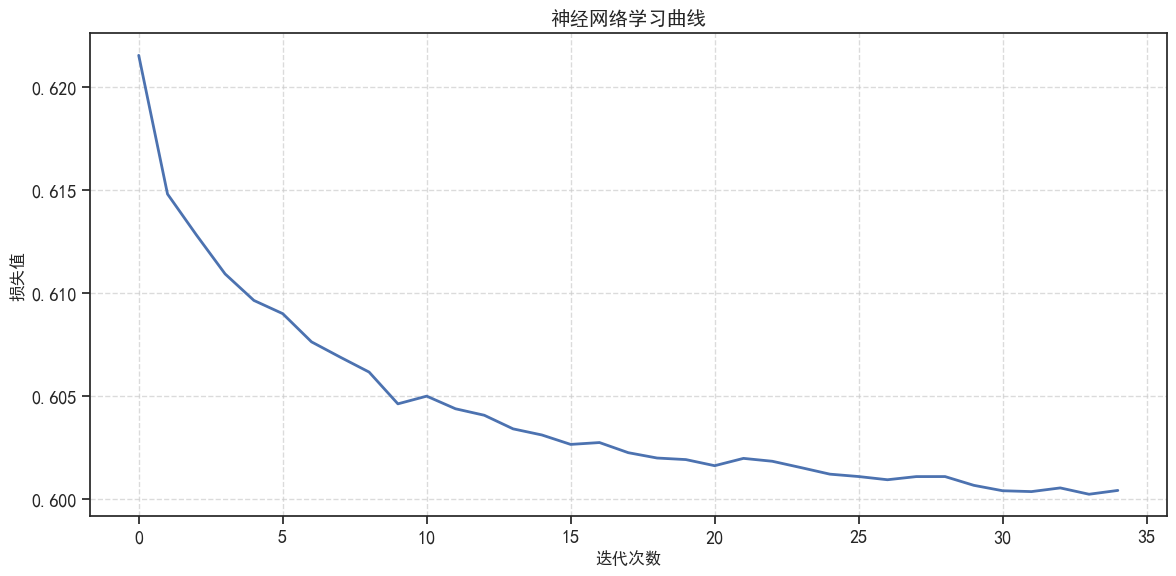


==== 最佳神经网络详细信息 ====
隐藏层结构: (128, 64, 32)
激活函数: tanh
优化器: adam
L2正则化参数: 0.01
学习率: 0.001
训练迭代次数: 35
训练时的最佳验证分数: 0.6636

==== 随机森林特征重要性 ====


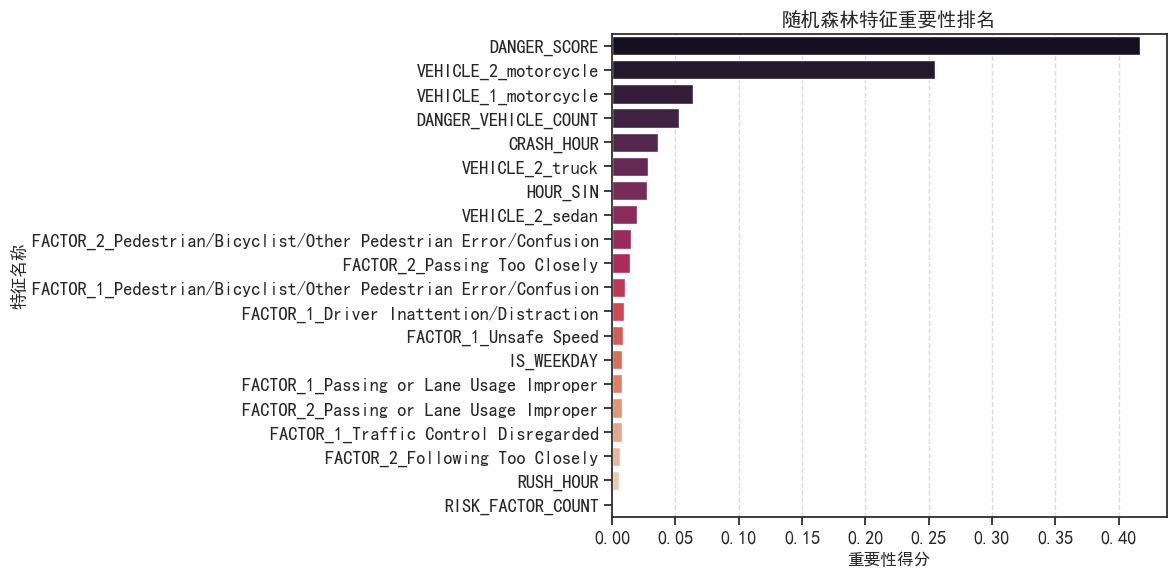

In [48]:
# ==============================
# 模型训练阶段：划分训练集/测试集
# ==============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import time
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False
rc = {'font.sans-serif': 'SimHei', 'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc, font_scale=1.2)

# 设置随机种子
np.random.seed(123)

# 1. 更新为最终特征列表
selected_features = final_features_list
X = final_features[selected_features]
y = final_features['HAS_CASUALTY']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=123, stratify=y
)

# 2. 评估函数
def evaluate_model(model, X_train, X_test, y_train, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"准确率: {accuracy:.4f}")
    print(f"精确率: {precision:.4f}")
    print(f"召回率: {recall:.4f}")
    print(f"F1分数: {f1:.4f}")
    print("混淆矩阵:\n", cm)
    print(f"训练时间: {train_time:.2f}秒")
    print(f"预测时间: {predict_time:.2f}秒\n")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'train_time': train_time,
        'predict_time': predict_time,
        'model': model,
        'y_pred': y_pred
    }

# 3. 模型调优函数
def tune_model(model, param_grid, X_train, y_train, cv=5, n_iter=50):
    search = RandomizedSearchCV(
        model, param_grid, n_iter=n_iter, cv=cv, scoring='f1',
        n_jobs=-1, verbose=1, random_state=42
    )
    search.fit(X_train, y_train)
    print(f"最佳参数: {search.best_params_}")
    print(f"最佳F1分数: {search.best_score_:.4f}\n")
    return search.best_estimator_  

# 模型训练部分
results = {}

# 决策树模型
print("\n==== 决策树模型 ====")
dt_param_grid = {
    'max_depth': [None, 3, 6, 9],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini']
}
dt_model = DecisionTreeClassifier(random_state=42)
dt_best = tune_model(dt_model, dt_param_grid, X_train, y_train, n_iter=20)
results['Decision Tree'] = evaluate_model(dt_best, X_train, X_test, y_train, y_test)

# XGBoost模型
print("\n==== XGBoost模型 ====")
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_model = XGBClassifier(
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_best = tune_model(xgb_model, xgb_param_grid, X_train, y_train, n_iter=20)
results['XGBoost'] = evaluate_model(xgb_best, X_train, X_test, y_train, y_test)

# 逻辑回归模型
print("\n==== 逻辑回归模型 ====")
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=2000))
])
lr_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear']
}
lr_best = tune_model(lr_pipeline, lr_param_grid, X_train, y_train, n_iter=20)
results['Logistic Regression'] = evaluate_model(lr_best, X_train, X_test, y_train, y_test)

# 随机森林模型
print("\n==== 随机森林模型 ====")
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}
rf_model = RandomForestClassifier(random_state=42)
rf_best = tune_model(rf_model, rf_param_grid, X_train, y_train, n_iter=20)
results['Random Forest'] = evaluate_model(rf_best, X_train, X_test, y_train, y_test)

# 神经网络模型
print("\n==== 神经网络模型 ====")

# 构建神经网络管道
nn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(random_state=42))
])

# 定义参数搜索空间
nn_param_grid = {
    'classifier__hidden_layer_sizes': [(64,), (128,), (64, 32), (128, 64), (128, 64, 32)],  # 不同层数和神经元数量
    'classifier__activation': ['relu', 'tanh'],  # 激活函数
    'classifier__solver': ['adam'],  # 优化器
    'classifier__alpha': [0.001, 0.01],  # L2正则化参数
    'classifier__learning_rate_init': [0.001, 0.01],  # 初始学习率
    'classifier__batch_size': [64, 128],  # 批大小
    'classifier__max_iter': [1000],  # 最大迭代次数
    'classifier__early_stopping': [True],  # 早停
    'classifier__n_iter_no_change': [20],  # 早停前迭代次数
    'classifier__validation_fraction': [0.2]  # 验证集比例
}

# 迭代次数和分层交叉验证
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nn_best = tune_model(nn_pipeline, nn_param_grid, X_train, y_train, cv=cv, n_iter=25)
results['Neural Network'] = evaluate_model(nn_best, X_train, X_test, y_train, y_test)

# 绘制神经网络学习曲线
plt.figure(figsize=(12, 6))
plt.plot(nn_best.named_steps['classifier'].loss_curve_, linewidth=2)
plt.title('神经网络学习曲线', fontsize=14)
plt.xlabel('迭代次数', fontsize=12)
plt.ylabel('损失值', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 输出最佳神经网络的详细信息
best_nn = nn_best.named_steps['classifier']
print("\n==== 最佳神经网络详细信息 ====")
print(f"隐藏层结构: {best_nn.hidden_layer_sizes}")
print(f"激活函数: {best_nn.activation}")
print(f"优化器: {best_nn.solver}")
print(f"L2正则化参数: {best_nn.alpha}")
print(f"学习率: {best_nn.learning_rate_init}")
print(f"训练迭代次数: {best_nn.n_iter_}")
print(f"训练时的最佳验证分数: {best_nn.best_validation_score_:.4f}")

# 9. 特征重要性可视化（以随机森林为例）
print("\n==== 随机森林特征重要性 ====")
rf_importance = pd.Series(
    results['Random Forest']['model'].feature_importances_,
    index=selected_features
).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=rf_importance.values, y=rf_importance.index, palette='rocket')
plt.title('随机森林特征重要性排名', fontsize=14)
plt.xlabel('重要性得分', fontsize=12)
plt.ylabel('特征名称', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# results

## 6.模型性能对比（可视化）


模型性能对比表（按F1-Score降序排列）：


,Model,Accuracy,Precision,Recall,F1-Score,AUC,Train Time (s),Predict Time (s)
1,XGBoost,0.6525,0.6431,0.8726,0.7405,0.7161,0.06,0.00
0,Decision Tree,0.6525,0.6460,0.8591,0.7375,0.7066,0.02,0.00
3,Random Forest,0.6627,0.6648,0.8195,0.7341,0.7249,2.26,0.05
2,Logistic Regression,0.6602,0.6735,0.7799,0.7228,0.7189,0.07,0.00
4,Neural Network,0.6535,0.6722,0.7615,0.7141,0.7236,12.07,0.01


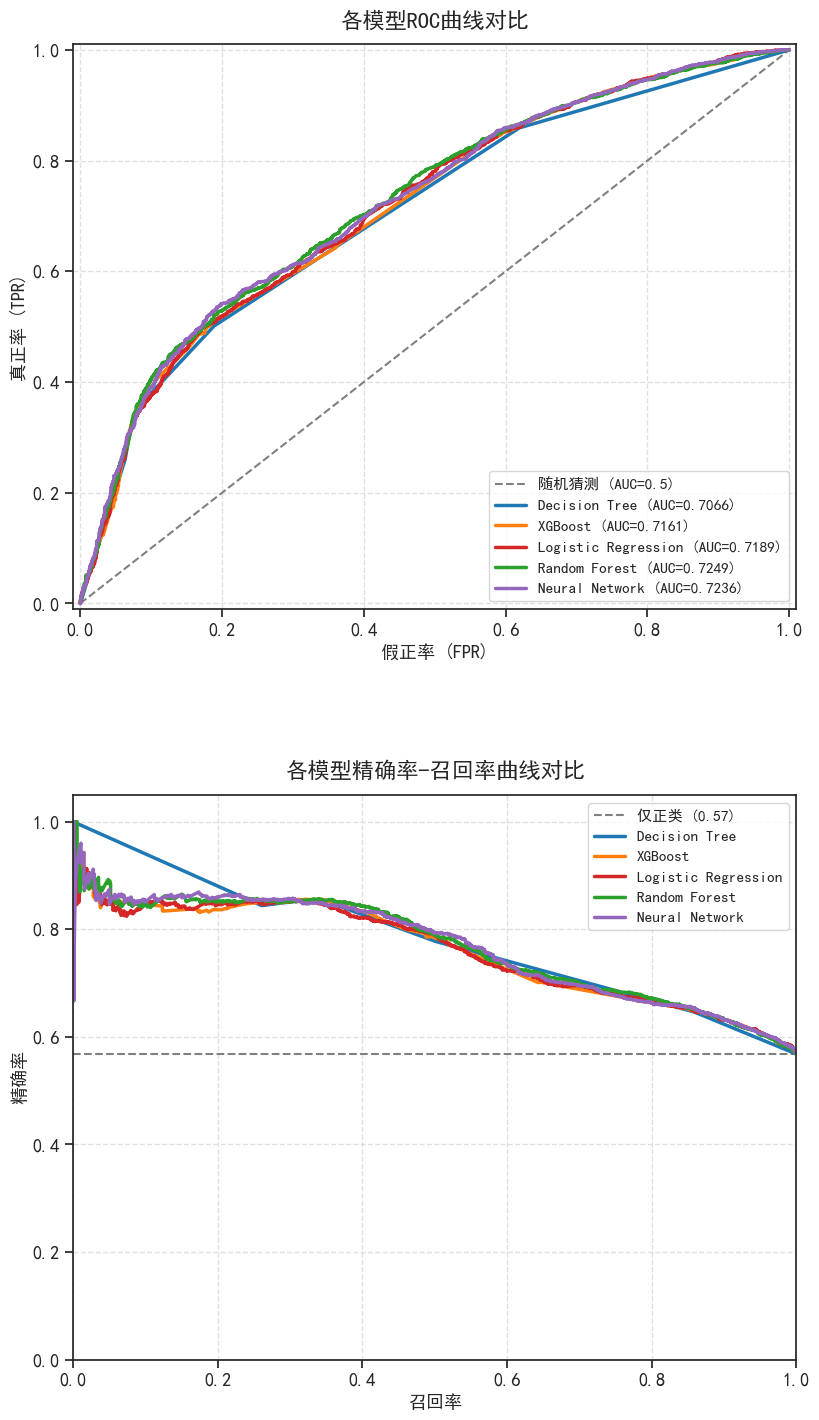

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve

# 设置中文字体
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False
rc = {'font.sans-serif': 'SimHei', 'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc, font_scale=1.2)

# 1. 生成包含完整指标的对比表格
comparison_data = []
for model_name, result in results.items():
    model = result['model']
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else \
             (model.decision_function(X_test) - model.decision_function(X_test).min()) / \
             (model.decision_function(X_test).max() - model.decision_function(X_test).min())
    comparison_data.append({
        'Model': model_name,
        'Accuracy': result['accuracy'],
        'Precision': result['precision'],
        'Recall': result['recall'],
        'F1-Score': result['f1'],
        'AUC': roc_auc_score(y_test, y_prob),
        'Train Time (s)': result['train_time'],
        'Predict Time (s)': result['predict_time']
    })

comparison_df = pd.DataFrame(comparison_data).sort_values(
    by=['F1-Score', 'AUC', 'Accuracy'], ascending=False
).round({'Accuracy': 4, 'Precision': 4, 'Recall': 4, 
         'F1-Score': 4, 'AUC': 4, 'Train Time (s)': 2, 'Predict Time (s)': 2})

print("\n模型性能对比表（按F1-Score降序排列）：")
display(comparison_df.style.set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
]).format({
    'Accuracy': '{:.4f}', 'Precision': '{:.4f}', 'Recall': '{:.4f}',
    'F1-Score': '{:.4f}', 'AUC': '{:.4f}', 'Train Time (s)': '{:.2f}',
    'Predict Time (s)': '{:.2f}'
}).background_gradient(cmap='Blues', subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']))

# 2. 绘制一列三行布局
fig = plt.figure(figsize=(10, 16))  # 调整为瘦高画布，适合一列三行

# 定义颜色映射
color_map = {
    'Decision Tree': '#1f77b4', 'XGBoost': '#ff7f0e',
    'Logistic Regression': '#d62728', 'Random Forest': '#2ca02c',
    'Neural Network': '#9467bd'
}

# 子图1：ROC曲线（占满宽度）
ax1 = fig.add_subplot(2, 1, 1)  # 一列三行，第1个
ax1.plot([0, 1], [0, 1], linestyle='--', color='gray', label='随机猜测 (AUC=0.5)')

for model_name, result in results.items():
    y_prob = result['model'].predict_proba(X_test)[:, 1] if hasattr(result['model'], 'predict_proba') else \
             (result['model'].decision_function(X_test) - result['model'].decision_function(X_test).min()) / \
             (result['model'].decision_function(X_test).max() - result['model'].decision_function(X_test).min())
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax1.plot(fpr, tpr, linewidth=2.5, color=color_map[model_name], 
             label=f'{model_name} (AUC={auc(fpr, tpr):.4f})')

ax1.set_xlim(-0.01, 1.01); ax1.set_ylim(-0.01, 1.01)
ax1.set_xlabel('假正率 (FPR)', fontsize=13); ax1.set_ylabel('真正率 (TPR)', fontsize=13)
ax1.set_title('各模型ROC曲线对比', fontsize=16, pad=12)
ax1.legend(loc='lower right', fontsize=11, frameon=True)
ax1.grid(True, linestyle='--', alpha=0.6)

# 子图2：精确率-召回率曲线（占满宽度）
ax2 = fig.add_subplot(2, 1, 2)  # 一列三行，第2个
ax2.axhline(y=y_test.mean(), linestyle='--', color='gray', label=f'仅正类 ({y_test.mean():.2f})')

for model_name, result in results.items():
    y_prob = result['model'].predict_proba(X_test)[:, 1] if hasattr(result['model'], 'predict_proba') else \
             (result['model'].decision_function(X_test) - result['model'].decision_function(X_test).min()) / \
             (result['model'].decision_function(X_test).max() - result['model'].decision_function(X_test).min())
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ax2.plot(recall, precision, linewidth=2.5, color=color_map[model_name], label=f'{model_name}')

ax2.set_xlabel('召回率', fontsize=13); ax2.set_ylabel('精确率', fontsize=13)
ax2.set_title('各模型精确率-召回率曲线对比', fontsize=16, pad=12)
ax2.legend(loc='upper right', fontsize=11, frameon=True)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_ylim([0.0, 1.05]); ax2.set_xlim([0.0, 1.0])


# 整体布局优化
plt.tight_layout(pad=5.0)  # 增加子图间距
plt.show()

## 7.模型可视化/模型解释


这段代码用于**可视化分析模型特征重要性与结构**，核心功能：  
1. **决策树结构**：绘制简易决策树（限制深度）。  
2. **线性模型（逻辑回归）**：可视化系数绝对值，区分正负向影响。  
3. **树模型（随机森林/XGBoost）**：展示特征重要性，尝试SHAP值分析。  
4. **神经网络**：可视化第一层权重分布。  
5. **跨模型比较**：综合多模型特征重要性，找出关键特征（如`DANGER_SCORE`、摩托车类型）。  
**工具**：Matplotlib/Seaborn绘图，SHAP（可选）增强解释性。


==== 简易决策树可视化 ====


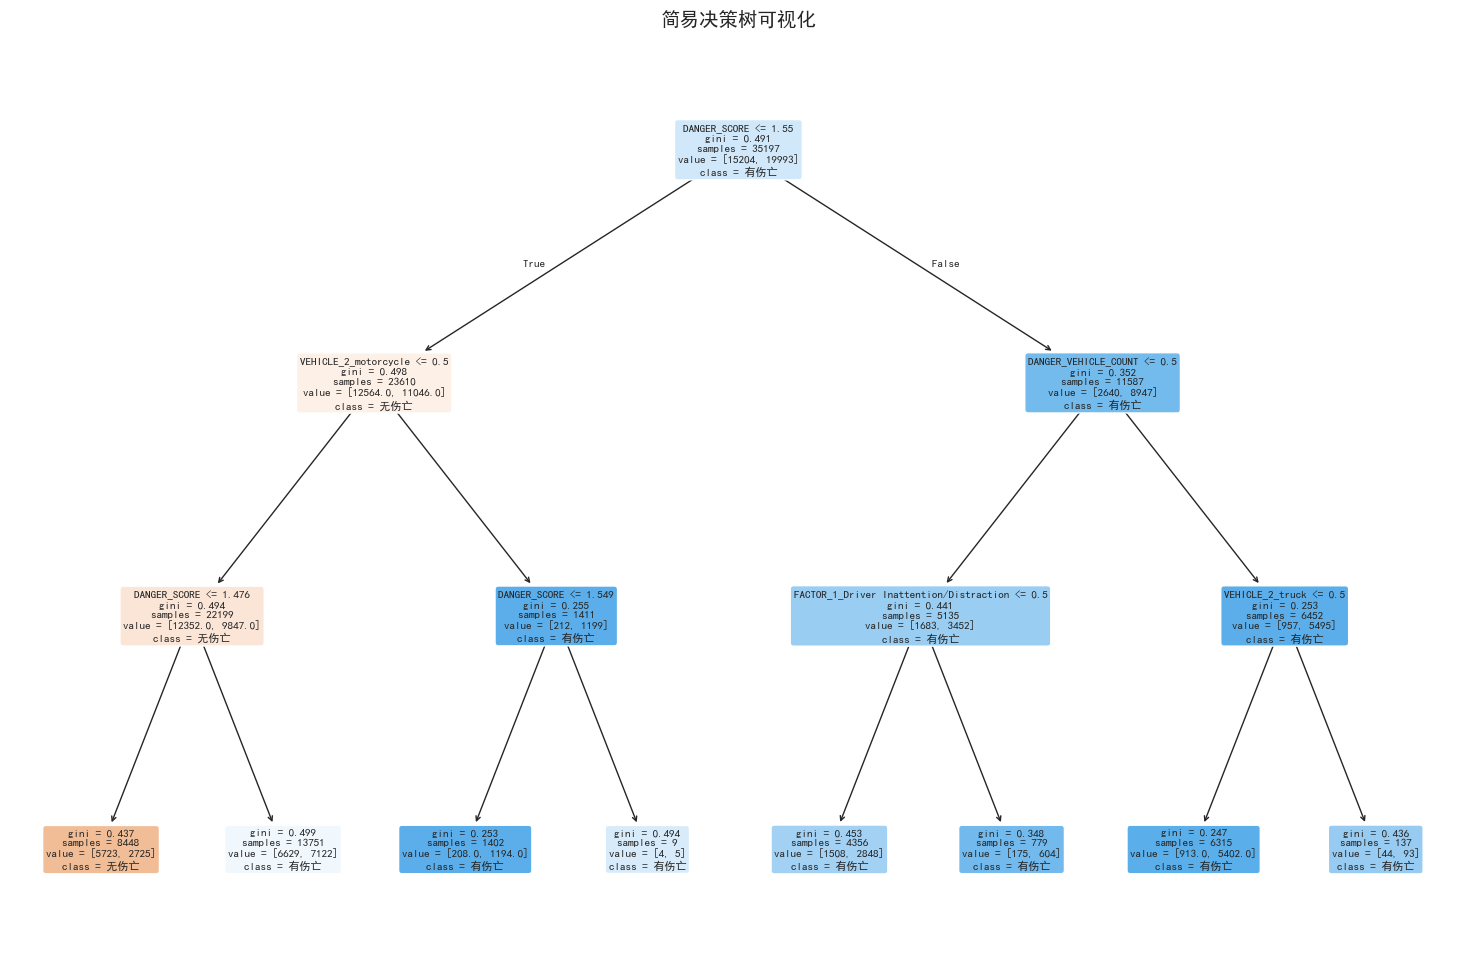


==== 逻辑回归系数可视化 ====


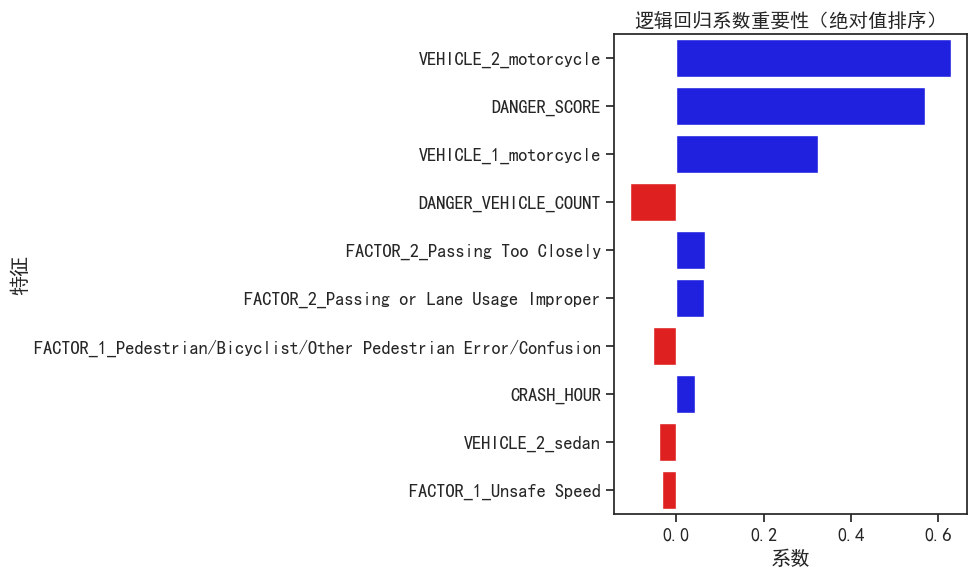


==== 神经网络权重分布 ====


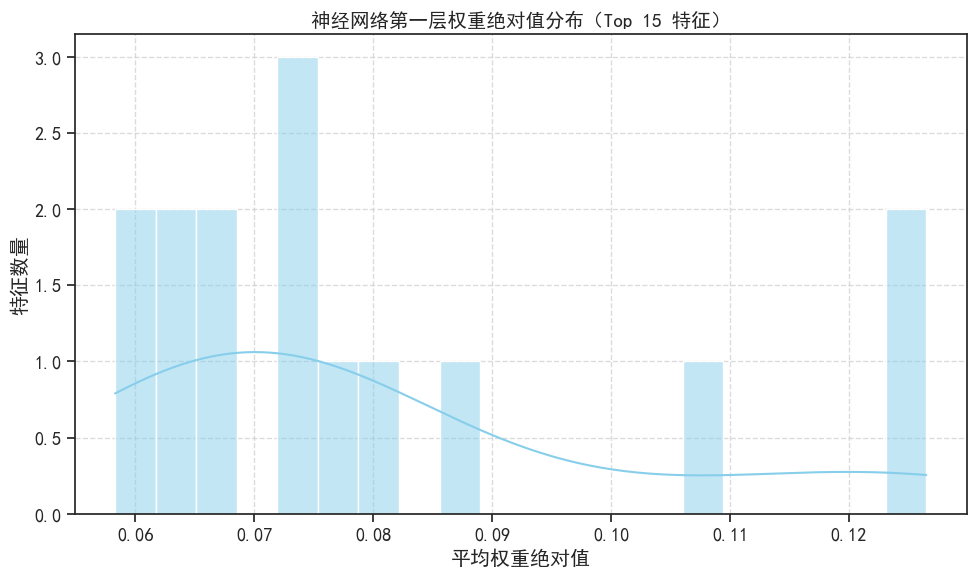


==== 随机森林特征重要性 ====


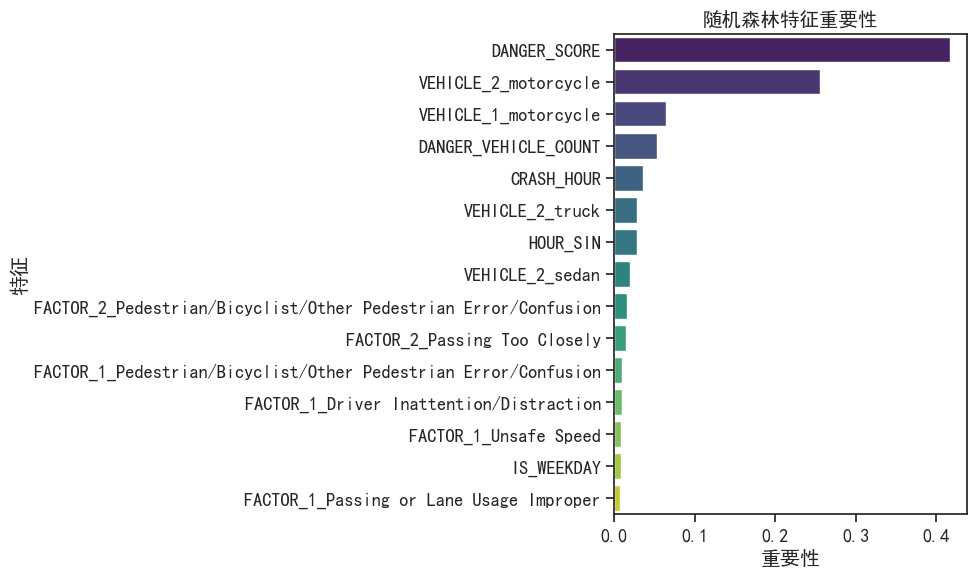


==== XGBoost特征重要性 ====


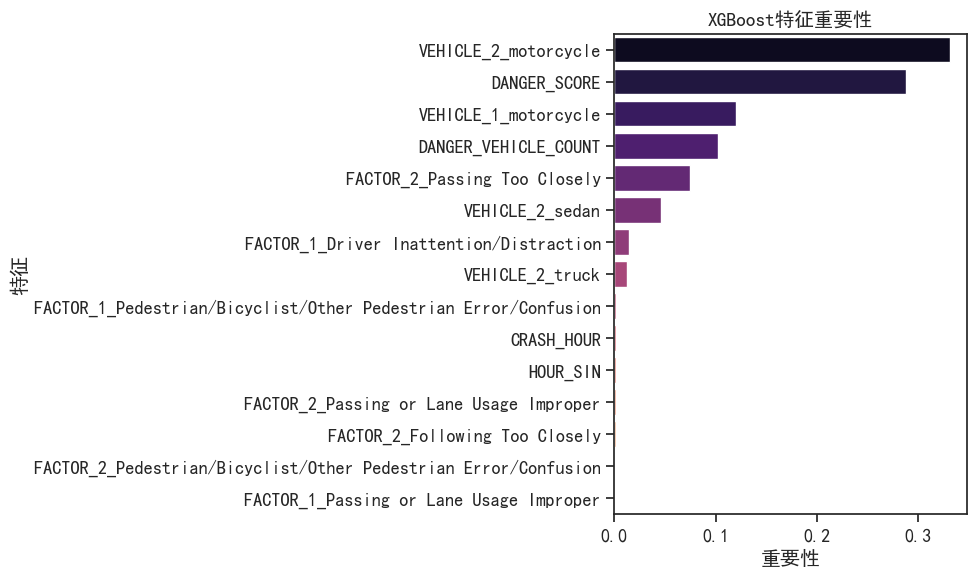

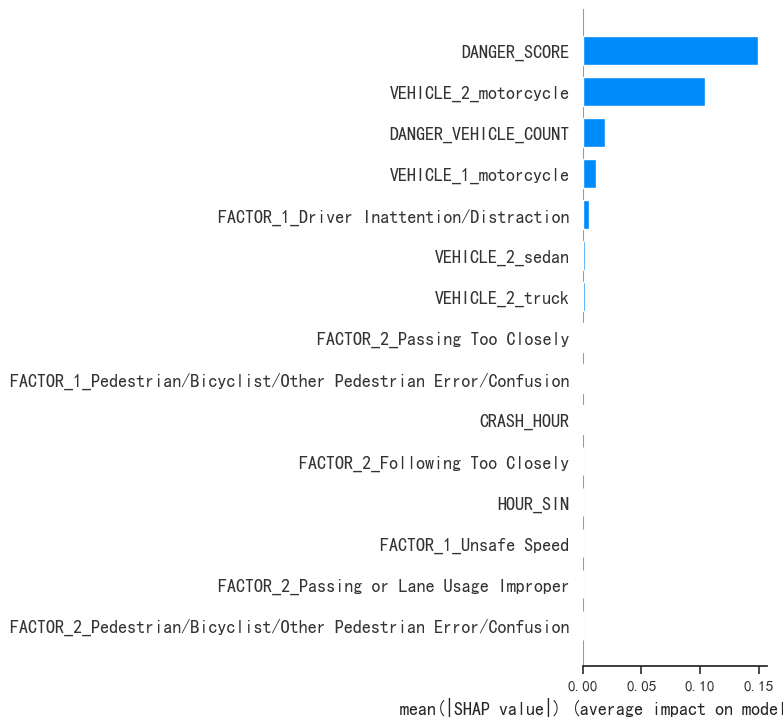


==== 特征重要性综合比较 ====


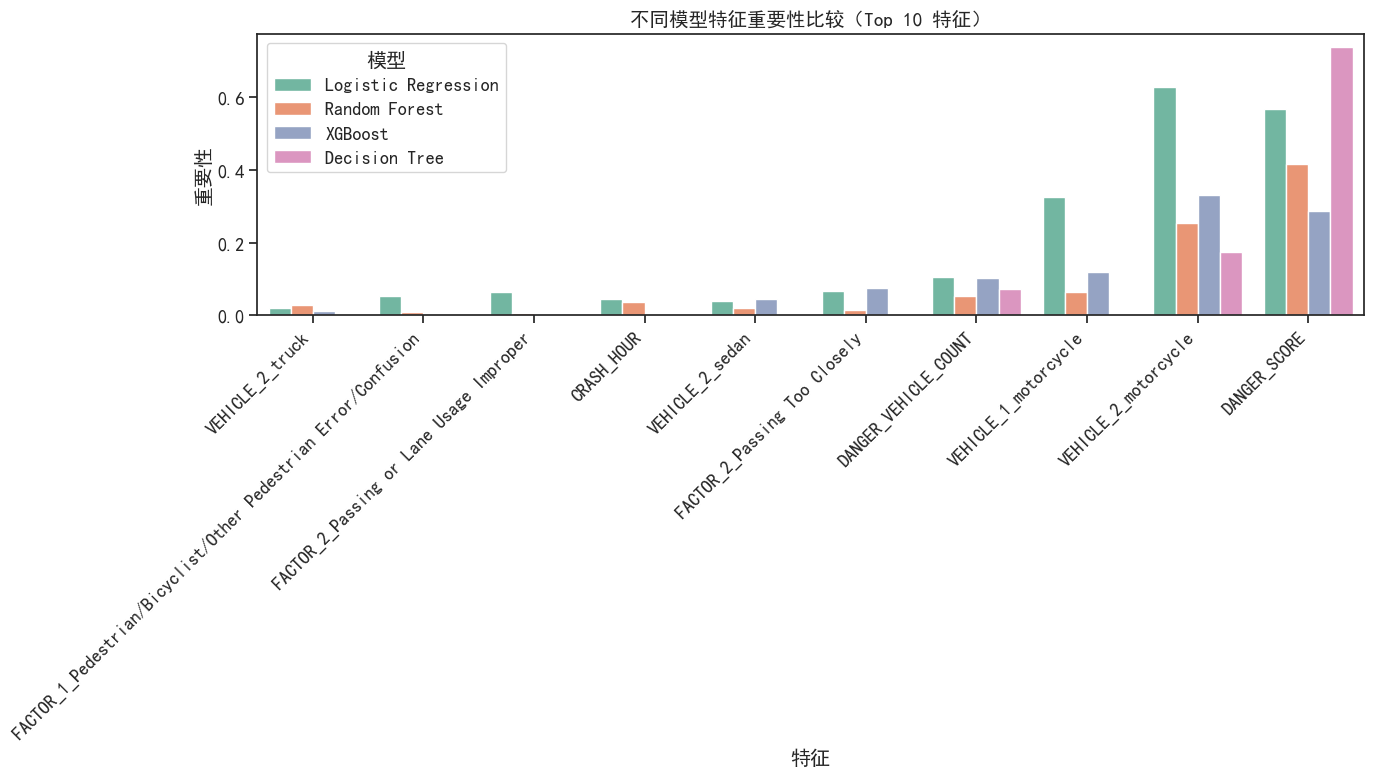

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.tree import plot_tree  # 新增plot_tree用于简易决策树绘制
from sklearn.inspection import permutation_importance
import shap

# 设置中文字体
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False
rc = {'font.sans-serif': 'SimHei', 'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc, font_scale=1.2)

# 1. 简易决策树可视化
def visualize_simple_decision_tree(model, feature_names, class_names=['无伤亡', '有伤亡'], max_depth=3):
    plt.figure(figsize=(15, 10))
    plot_tree(
        model,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        max_depth=max_depth,  # 控制树的深度
        fontsize=8,
        rounded=True
    )
    plt.title('简易决策树可视化', fontsize=14)
    plt.tight_layout()
    plt.show()

# 2. 逻辑回归系数可视化
def visualize_logistic_regression_coefficients(model, feature_names, top_n=10):
    if hasattr(model, 'named_steps'):  # 如果是Pipeline
        coef = model.named_steps['classifier'].coef_[0]
    else:
        coef = model.coef_[0]
    
    coef_df = pd.DataFrame({
        '特征': feature_names,
        '系数': coef
    }).sort_values(by='系数', key=abs, ascending=False)
    
    plt.figure(figsize=(10, 6))
    colors = ['red' if c < 0 else 'blue' for c in coef_df['系数']]
    sns.barplot(x='系数', y='特征', data=coef_df.head(top_n), palette=colors)
    plt.title('逻辑回归系数重要性（绝对值排序）', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return coef_df.head(top_n)

# 3. 神经网络权重直方图可视化
def visualize_nn_weights_histogram(model, feature_names, layer=0, top_n=15):
    if hasattr(model, 'named_steps'):  # 如果是Pipeline
        weights = model.named_steps['classifier'].coefs_[layer]
    else:
        weights = model.coefs_[layer]
    
    # 计算每个特征的平均权重绝对值
    avg_weights = np.mean(np.abs(weights), axis=1)
    weight_df = pd.DataFrame({
        '特征': feature_names,
        '平均权重绝对值': avg_weights
    }).sort_values(by='平均权重绝对值', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.histplot(weight_df['平均权重绝对值'], bins=20, kde=True, color='skyblue')
    plt.title(f'神经网络第一层权重绝对值分布（Top {top_n} 特征）', fontsize=14)
    plt.xlabel('平均权重绝对值')
    plt.ylabel('特征数量')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return weight_df

# 4. 随机森林特征重要性
def visualize_rf_feature_importance(model, feature_names, top_n=15):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'named_steps'):
        importance = model.named_steps['classifier'].feature_importances_
    else:
        raise ValueError("模型不支持特征重要性获取")
    
    importance_df = pd.DataFrame({
        '特征': feature_names,
        '重要性': importance
    }).sort_values(by='重要性', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='重要性', y='特征', data=importance_df, palette='viridis')
    plt.title('随机森林特征重要性', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return importance_df

# 5. XGBoost特征重要性
def visualize_xgb_feature_importance(model, feature_names, top_n=15):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'named_steps'):
        importance = model.named_steps['classifier'].feature_importances_
    else:
        raise ValueError("模型不支持特征重要性获取")
    
    importance_df = pd.DataFrame({
        '特征': feature_names,
        '重要性': importance
    }).sort_values(by='重要性', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='重要性', y='特征', data=importance_df, palette='magma')
    plt.title('XGBoost特征重要性', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # SHAP值可视化
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_type="bar", max_display=top_n)
    except Exception as e:
        print(f"SHAP可视化失败: {e}")
    
    return importance_df

# 6. 特征重要性综合比较
def compare_feature_importance(models, feature_names, top_n=10):
    importance_scores = {}
    
    for model_name, model in models.items():
        try:
            if model_name == 'Logistic Regression':
                if hasattr(model, 'named_steps'):
                    coef = model.named_steps['classifier'].coef_[0]
                else:
                    coef = model.coef_[0]
                importance = np.abs(coef)
            elif model_name in ['Random Forest', 'XGBoost', 'Decision Tree']:
                if hasattr(model, 'feature_importances_'):
                    importance = model.feature_importances_
                elif hasattr(model, 'named_steps'):
                    importance = model.named_steps['classifier'].feature_importances_
                else:
                    continue
            else:  # 其他模型使用排列重要性
                result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
                importance = result.importances_mean
                
            importance_scores[model_name] = importance
            
        except Exception as e:
            print(f"获取{model_name}特征重要性失败: {e}")
    
    # 计算平均重要性并选择top_n特征
    avg_importance = np.mean([scores for scores in importance_scores.values()], axis=0)
    top_indices = np.argsort(avg_importance)[-top_n:]
    top_features = [feature_names[i] for i in top_indices]
    
    # 创建DataFrame
    importance_df = pd.DataFrame(index=top_features)
    for model_name, scores in importance_scores.items():
        importance_df[model_name] = [scores[i] for i in top_indices]
    
    # 将索引重置为列（特征名称）
    importance_df = importance_df.reset_index().rename(columns={'index': '特征'})
    
    # 转换为长格式数据
    melted_df = importance_df.melt(id_vars='特征', var_name='模型', value_name='重要性')
    
    # 可视化
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(data=melted_df, x='特征', y='重要性', hue='模型', palette='Set2')
    plt.title('不同模型特征重要性比较（Top 10 特征）', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# 运行所有可视化函数
if __name__ == "__main__":
 
    # 1. 简易决策树可视化
    print("\n==== 简易决策树可视化 ====")
    visualize_simple_decision_tree(results['Decision Tree']['model'], selected_features)
    
    # 2. 逻辑回归系数可视化
    print("\n==== 逻辑回归系数可视化 ====")
    visualize_logistic_regression_coefficients(results['Logistic Regression']['model'], selected_features)
    
    # 3. 神经网络权重直方图可视化
    print("\n==== 神经网络权重分布 ====")
    visualize_nn_weights_histogram(results['Neural Network']['model'], selected_features)
    
    # 4. 随机森林特征重要性
    print("\n==== 随机森林特征重要性 ====")
    visualize_rf_feature_importance(results['Random Forest']['model'], selected_features)
    
    # 5. XGBoost特征重要性
    print("\n==== XGBoost特征重要性 ====")
    visualize_xgb_feature_importance(results['XGBoost']['model'], selected_features)
    
    # 6. 特征重要性综合比较（柱状图）
    print("\n==== 特征重要性综合比较 ====")
    models_to_compare = {
        'Logistic Regression': results['Logistic Regression']['model'],
        'Random Forest': results['Random Forest']['model'],
        'XGBoost': results['XGBoost']['model'],
        'Decision Tree': results['Decision Tree']['model']
    }
    compare_feature_importance(models_to_compare, selected_features)

In [ ]:
# processed_df.info()

#### 模型应用

In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# 加载最终特征和目标变量
selected_features = final_features_list
X = final_features[selected_features]
y = final_features['HAS_CASUALTY']

# 划分训练集/测试集（测试集占比10%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=123, stratify=y
)

# 初始化并训练随机森林模型
# 最佳参数: {'n_estimators': 200, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10}
model = RandomForestClassifier(
    n_estimators=200,       # 最佳树数量
    min_samples_leaf=2,     # 叶子节点最小样本数
    max_features='sqrt',    # 最佳特征选择策略
    random_state=123,       # 固定随机种子
)
model.fit(X_train, y_train)

# 模型预测
y_pred = model.predict(X_test)

# 输出评估结果
print("==== 模型评估结果 ====")
print(f"测试集准确率: {accuracy_score(y_test, y_pred):.4f}")
print("混淆矩阵:\n", confusion_matrix(y_test, y_pred))

# 输出前10个预测结果（示例）
print("\n==== 部分预测结果示例 ====")
prediction_df = pd.DataFrame({
    '真实标签': y_test.values[:10],
    '预测标签': y_pred[:10]
})
print(prediction_df)

==== 模型评估结果 ====
测试集准确率: 0.6446
混淆矩阵:
 [[ 943  746]
 [ 644 1578]]

==== 部分预测结果示例 ====
    真实标签   预测标签
0  False   True
1  False  False
2  False  False
3   True   True
4  False  False
5   True   True
6   True   True
7   True   True
8   True  False
9  False  False


### EDA

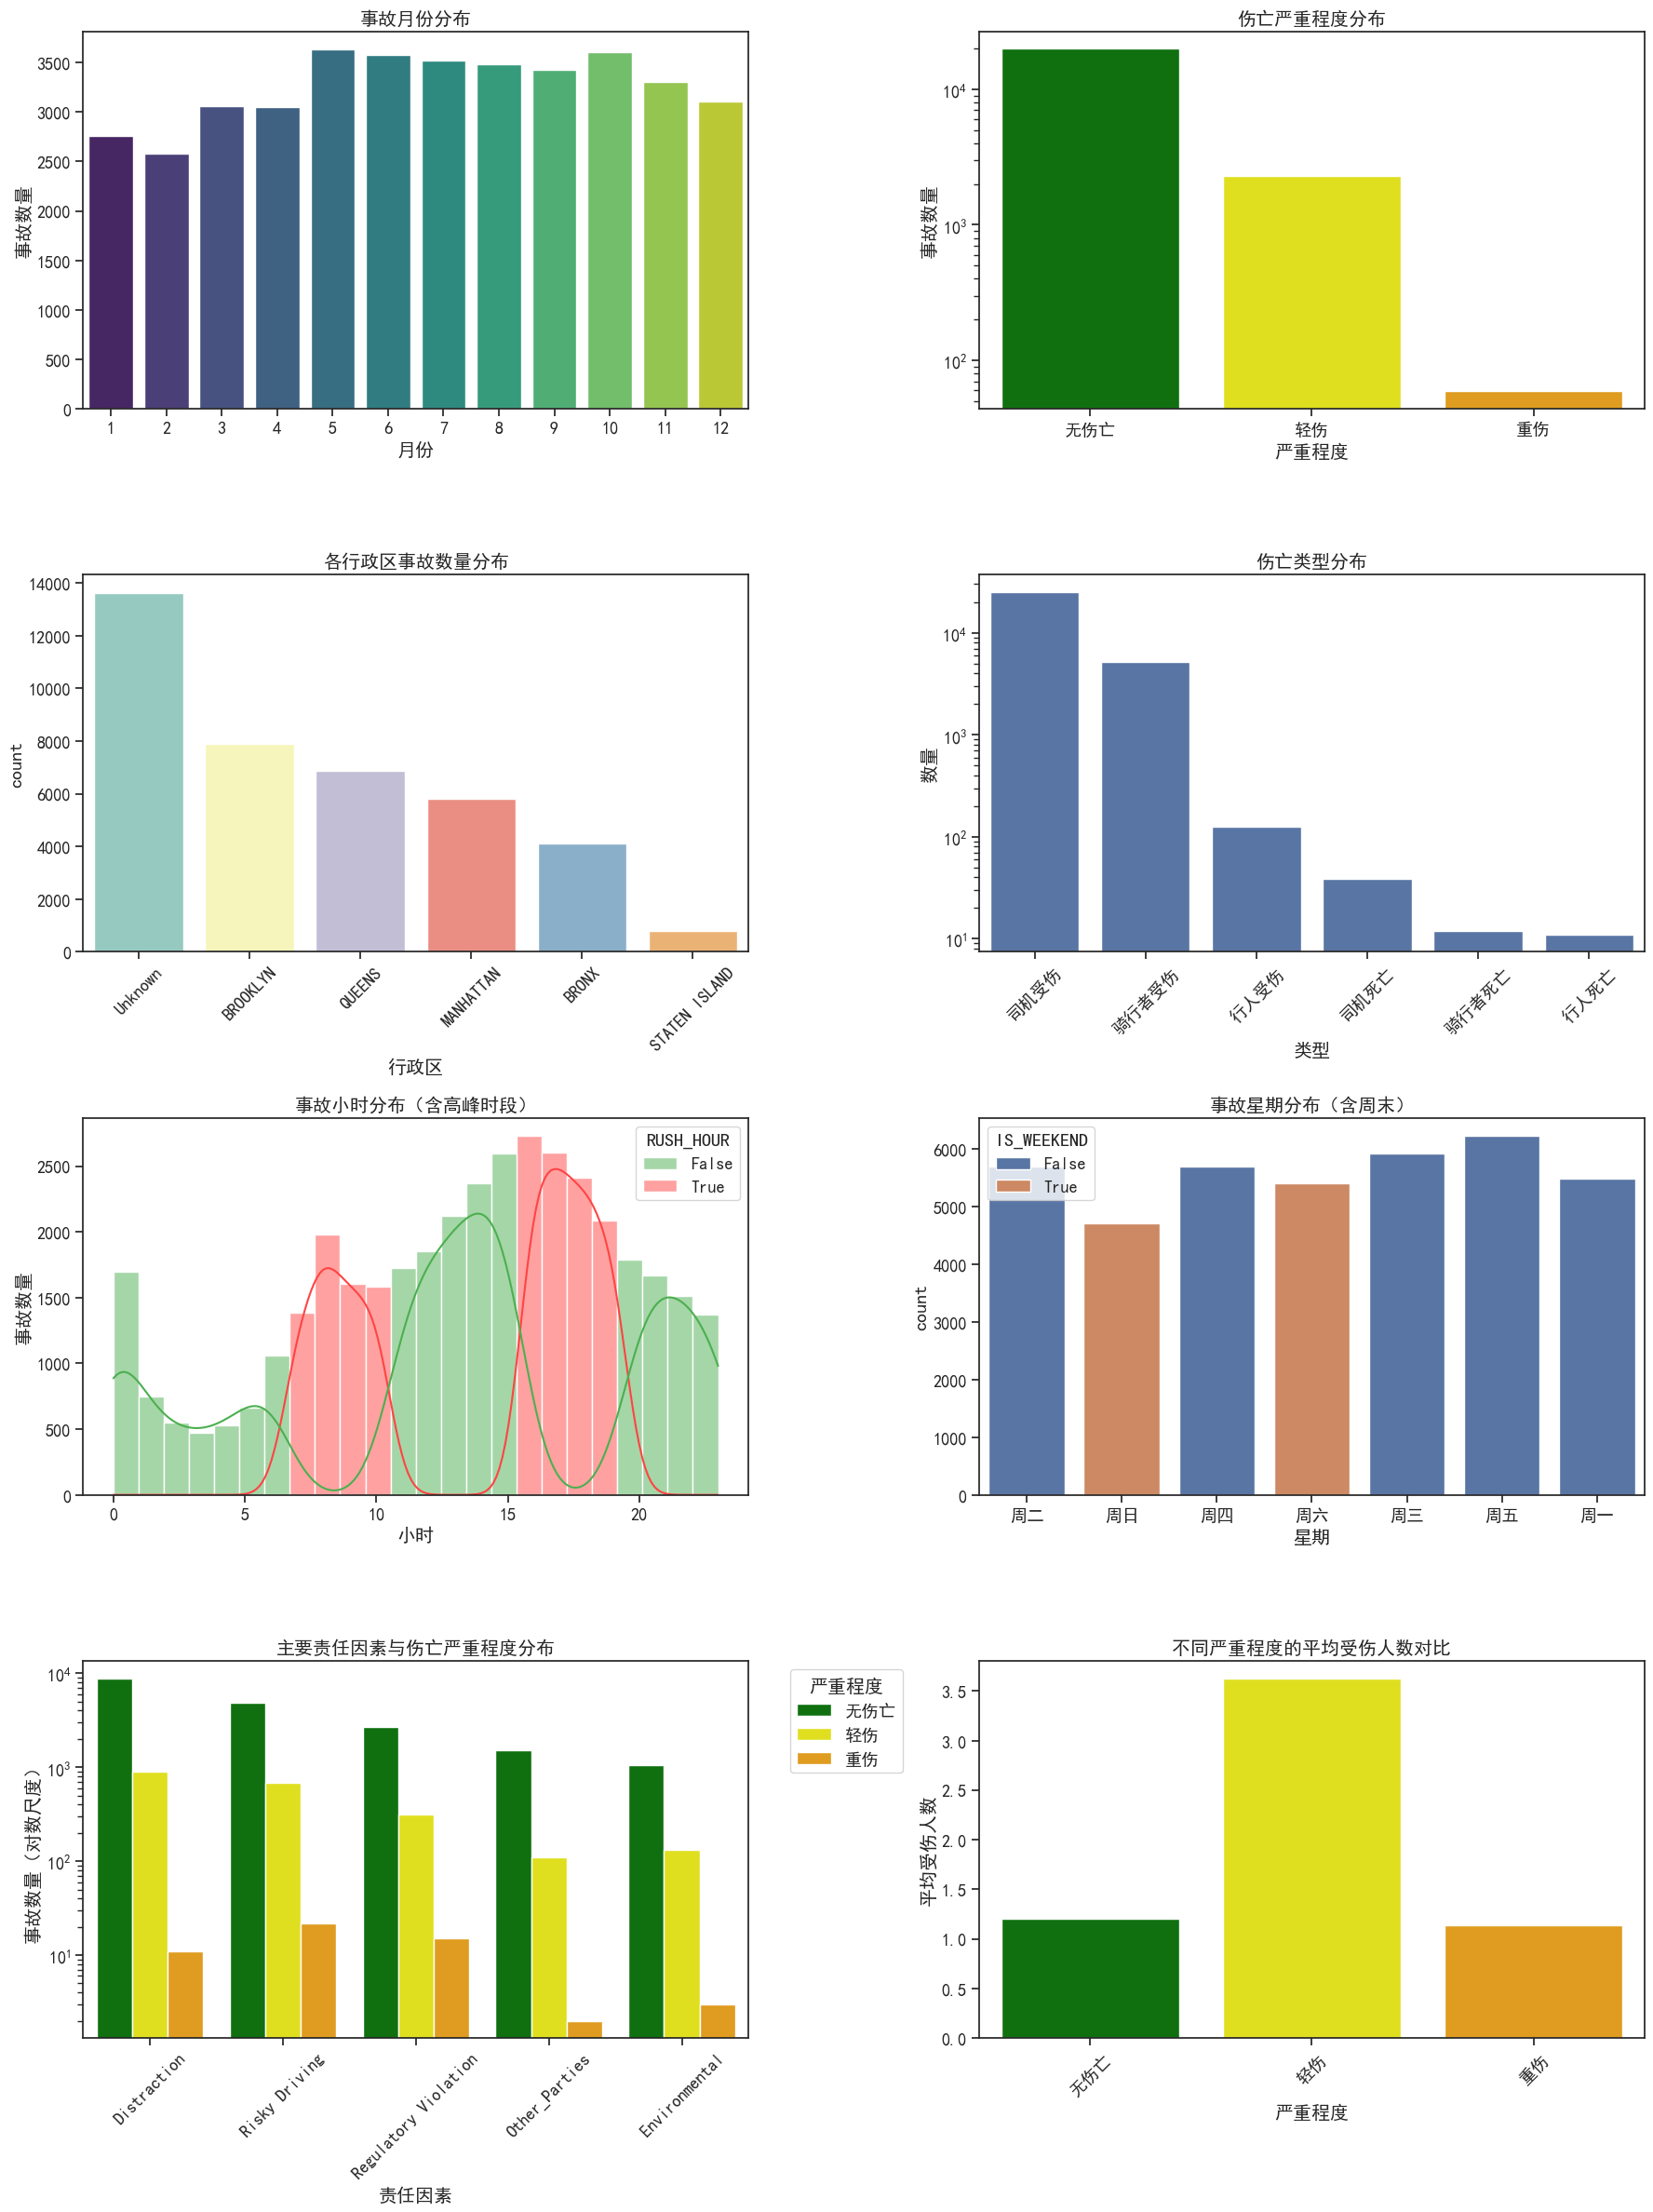

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap, MarkerCluster
import numpy as np

# 设置中文字体
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False
rc = {'font.sans-serif': 'SimHei', 'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc, font_scale=1.2)
plt.rcParams["figure.figsize"] = (18, 24)  # 调整整体图表大小

# ----------------------
# 列名中文映射（适配新数据）
# ----------------------
col_map = {
    'BOROUGH': '行政区',
    'NUMBER OF PERSONS INJURED': '受伤人数',
    'NUMBER OF PERSONS KILLED': '死亡人数',
    'SEVERITY': '严重程度',
    'HAS_CASUALTY': '是否伤亡',
    'RUSH_HOUR': '高峰时段',
    'IS_WEEKEND': '是否周末',
    'IS_WEEKDAY': '是否工作日',
    'IS_FEDERAL_HOLIDAY': '是否联邦假期',
    'CONTRIBUTING FACTOR VEHICLE 1_CATEGORY': '主要责任因素',
    'VEHICLE TYPE CODE 1': '车辆类型',
    'CRASH_DATETIME': '事故时间',  # 正确时间列
    'MONTH': '月份',
    'HOUR': '小时'
}

# ----------------------
# 严重程度映射
# ----------------------
severity_info = {
    1: {'cn': '无伤亡', 'color': 'green'},
    2: {'cn': '轻伤', 'color': 'yellow'},
    3: {'cn': '重伤', 'color': 'orange'},
    4: {'cn': '死亡', 'color': 'red'}
}

# 验证并处理SEVERITY未知值
valid_severity = severity_info.keys()
processed_df['SEVERITY'] = processed_df['SEVERITY'].apply(
    lambda x: x if x in valid_severity else np.nan
)

# ----------------------
# 基础分析图（Seaborn）
# ----------------------
plt.figure(figsize=(18, 24))  # 调整整体图表大小

# 1. 事故月份分布
plt.subplot(4, 2, 1)
monthly_accidents = processed_df['MONTH'].value_counts().sort_index()
sns.barplot(x=monthly_accidents.index, y=monthly_accidents.values, palette='viridis')
plt.title('事故月份分布')
plt.xlabel('月份')
plt.ylabel('事故数量')

# 2. 伤亡严重程度分布
plt.subplot(4, 2, 2)
severity_counts = processed_df['SEVERITY'].value_counts().sort_index()
sns.barplot(
    x=[severity_info.get(s, {'cn': '未知'})['cn'] for s in severity_counts.index],
    y=severity_counts.values,
    palette=[severity_info.get(s, {'color': 'gray'})['color'] for s in severity_counts.index]
)
plt.title('伤亡严重程度分布')
plt.xlabel('严重程度')
plt.ylabel('事故数量')
plt.yscale('log')  # 使用对数尺度，解决小数据看不见的问题

# 3. 行政区事故分布
plt.subplot(4, 2, 3)
sns.countplot(
    x='BOROUGH', 
    data=processed_df, 
    order=processed_df['BOROUGH'].value_counts().index,
    palette='Set3'
)
plt.title('各行政区事故数量分布')
plt.xlabel('行政区')
plt.xticks(rotation=45)

# 4. 伤亡类型分布（调整为对数尺度）
plt.subplot(4, 2, 4)
casualty_types = [
    ('行人受伤', 'NUMBER OF PEDESTRIANS INJURED'),
    ('行人死亡', 'NUMBER OF PEDESTRIANS KILLED'),
    ('骑行者受伤', 'NUMBER OF CYCLIST INJURED'),
    ('骑行者死亡', 'NUMBER OF CYCLIST KILLED'),
    ('司机受伤', 'NUMBER OF MOTORIST INJURED'),
    ('司机死亡', 'NUMBER OF MOTORIST KILLED')
]
casualty_data = pd.DataFrame({
    '类型': [t[0] for t in casualty_types],
    '数量': [processed_df[t[1]].sum() for t in casualty_types]
})
sns.barplot(x='类型', y='数量', data=casualty_data, order=casualty_data.sort_values('数量', ascending=False)['类型'])
plt.title('伤亡类型分布')
plt.xlabel('类型')
plt.ylabel('数量')
plt.yscale('log')  # 使用对数尺度，解决小数据看不见的问题
plt.xticks(rotation=45)

# 5. 事故小时分布
plt.subplot(4, 2, 5)
sns.histplot(
    data=processed_df,    
    x='HOUR',             
    bins=24,
    kde=True,
    hue='RUSH_HOUR',
    palette=['#4CAF50', '#FF4444']
)
plt.title('事故小时分布（含高峰时段）')
plt.xlabel('小时')
plt.ylabel('事故数量')

# 6. 事故星期分布
plt.subplot(4, 2, 6)
processed_df['DAY_NAME'] = processed_df['DAY_OF_WEEK'].map(
    {0:'周一', 1:'周二', 2:'周三', 3:'周四', 4:'周五', 5:'周六', 6:'周日'}
)
sns.countplot(x='DAY_NAME', data=processed_df, hue='IS_WEEKEND')
plt.title('事故星期分布（含周末）')
plt.xlabel('星期')

# 7. 主要责任因素与伤亡严重程度
plt.subplot(4, 2, 7)

# 步骤1：筛选高频责任因素（取前 5，可调整数量）
top_factors = processed_df['CONTRIBUTING FACTOR VEHICLE 1_CATEGORY'].value_counts().head(5).index
factor_severity = processed_df[processed_df['CONTRIBUTING FACTOR VEHICLE 1_CATEGORY'].isin(top_factors)]

# 步骤2：统计每个责任因素-严重程度的组合数量
factor_severity_counts = factor_severity.groupby(['CONTRIBUTING FACTOR VEHICLE 1_CATEGORY', 'SEVERITY']).size().reset_index(name='事故数量')

# 步骤3：映射严重程度为中文和颜色
factor_severity_counts['SEVERITY_CN'] = factor_severity_counts['SEVERITY'].map(
    {k: v['cn'] for k, v in severity_info.items()}
).fillna('未知')
factor_severity_counts['COLOR'] = factor_severity_counts['SEVERITY'].map(
    {k: v['color'] for k, v in severity_info.items()}
).fillna('gray')

# 步骤4：绘制分组柱状图，调整 y 轴为对数尺度
g = sns.barplot(
    x='CONTRIBUTING FACTOR VEHICLE 1_CATEGORY',
    y='事故数量',
    hue='SEVERITY_CN',  # 用中文显示图例
    data=factor_severity_counts,
    palette=factor_severity_counts['COLOR'].unique(),  # 确保颜色与严重程度对应
    order=top_factors
)

# 优化：y 轴对数尺度（让小类别更清晰）
g.set(yscale="log")

plt.title('主要责任因素与伤亡严重程度分布')
plt.xlabel('责任因素')
plt.ylabel('事故数量（对数尺度）')
plt.legend(title='严重程度', bbox_to_anchor=(1.05, 1), loc='upper left')  # 图例放右侧，避免挤压
plt.xticks(rotation=45)

# ----------------------
# 8. 伤亡严重程度与受伤人数关系（柱状对比图）
# ----------------------
plt.subplot(4, 2, 8)

# 按严重程度分组计算平均受伤人数
severity_injury_mean = processed_df.groupby('SEVERITY')['NUMBER OF PERSONS INJURED'].mean().reset_index()

# 映射严重程度为中文
severity_injury_mean['SEVERITY_CN'] = severity_injury_mean['SEVERITY'].map(
    {k: v['cn'] for k, v in severity_info.items()}
).fillna('未知')

# 绘制柱状图
sns.barplot(
    x='SEVERITY_CN', 
    y='NUMBER OF PERSONS INJURED', 
    data=severity_injury_mean,
    palette=[severity_info.get(s, {'color': 'gray'})['color'] for s in severity_injury_mean['SEVERITY']]
)

plt.title('不同严重程度的平均受伤人数对比')
plt.xlabel('严重程度')
plt.ylabel('平均受伤人数')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### 二、地理空间分析（简化版）
# 过滤有效地理数据
valid_geo = processed_df[
    (processed_df['LATITUDE'].between(40.5, 41)) &
    (processed_df['LONGITUDE'].between(-74.2, -73.7))
].copy()

# 处理行政区名称映射
borough_map = {
    'Bronx': '布朗克斯',
    'Brooklyn': '布鲁克林',
    'Manhattan': '曼哈顿',
    'Queens': '皇后区',
    'Staten Island': '史泰登岛'
}
valid_geo['BOROUGH_CN'] = valid_geo['BOROUGH'].map(borough_map).fillna('未知行政区')

# 处理严重程度映射
valid_geo['SEVERITY_CN'] = valid_geo['SEVERITY'].map({k: v['cn'] for k, v in severity_info.items()}).fillna('未知')

# 从CRASH_DATETIME提取日期和时间
valid_geo['事故日期'] = valid_geo['CRASH_DATETIME'].dt.date.astype(str)
valid_geo['事故时间'] = valid_geo['CRASH_DATETIME'].dt.time.astype(str)

# 1. 伤亡热力图（简化版）
casualty_map = folium.Map(
    location=[valid_geo['LATITUDE'].mean(), valid_geo['LONGITUDE'].mean()],
    zoom_start=11,
    tiles='CartoDB positron'
)

# 采样数据以提高性能
sample_ratio = 0.2
sampled_data = valid_geo.sample(frac=sample_ratio)

# 添加事故点标记
for _, row in sampled_data.iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=5,
        color=severity_info.get(row['SEVERITY'], {'color': 'gray'})['color'],
        fill=True,
        fill_color=severity_info.get(row['SEVERITY'], {'color': 'gray'})['color'],
        fill_opacity=0.7,
        tooltip=f"行政区: {row['BOROUGH_CN']}<br>严重程度: {row['SEVERITY_CN']}<br>时间: {row['事故日期']} {row['事故时间']}"  
    ).add_to(casualty_map)

# 添加图例
legend_html = """
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 9999;">
    <div style="background-color: white; padding: 10px; border-radius: 5px; box-shadow: 0 0 10px rgba(0,0,0,0.2);">
        <p><span style="display:inline-block; width:12px; height:12px; background-color:green; border-radius:50%; margin-right:5px;"></span>无伤亡</p>
        <p><span style="display:inline-block; width:12px; height:12px; background-color:yellow; border-radius:50%; margin-right:5px;"></span>轻伤</p>
        <p><span style="display:inline-block; width:12px; height:12px; background-color:orange; border-radius:50%; margin-right:5px;"></span>重伤</p>
        <p><span style="display:inline-block; width:12px; height:12px; background-color:red; border-radius:50%; margin-right:5px;"></span>死亡</p>
    </div>
</div>
"""
casualty_map.get_root().html.add_child(folium.Element(legend_html))

# 2. 严重程度聚类图
marker_map = folium.Map(
    location=[40.7128, -74.0060],
    zoom_start=12,
    tiles='CartoDB dark_matter'
)

# 采样数据以提高性能
if len(valid_geo) > 1000:  # 如果数据量超过1000，采样50%
    clustered_data = valid_geo.sample(frac=0.5)
else:
    clustered_data = valid_geo

# 添加聚类标记
marker_cluster = MarkerCluster().add_to(marker_map)

for _, row in clustered_data.iterrows():
    folium.Marker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        icon=folium.Icon(
            color=severity_info.get(row['SEVERITY'], {'color': 'gray'})['color'],
            icon='info-sign'
        ),
        popup=f"行政区: {row['BOROUGH_CN']}<br>严重程度: {row['SEVERITY_CN']}<br>时间: {row['事故日期']} {row['事故时间']}"  
    ).add_to(marker_cluster)

# 显示地图（Jupyter环境）
# display(casualty_map)
# display(marker_map)